
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Problem Statement </h2>


<strong>Problem Statement:</strong>

In Apparel and Footwear Industry, colour matching is a critical factor. For example, when a Lead Designer of a major fashion brand has picked the colour for the season, he/she would want the exact colour on the produced garments. This means all hundreds of thousands of garments need to have the same colour. This is challenging because there are so many factors affecting colour: for example, different materials (e.g. cotton, polyester, leather) have different dye absorption rate; water properties (pH, purity, etc); ambient temperature; dyes concentration; chemical properties; etc.

<br>
I have been provided 1 year(2017) of dataset split in to training and test data.
<br>
<br>
<strong>About Data and Variables</strong>

It is all the data received during dyeing process at particular dyecenters with proper batch id and parent id numbers.Training  data contains features has dye, fiber and substrate related information, test performed to check the colours and shade, weight and yarn related information, in total  67  features are present. 


<br><br>
<strong>Objective:</strong>

We want to build a model to predict probability of faliure (in dyeing exact colour) of the dyed batches and split them in to class "passed" and "failed". The probability score should be arrange in the descending order.
<br><br>

The test data also contains the same features, which is what your model should predict.

<strong>Evaluation Metric:</strong>

We will be using Area under the ROC curve to evaluate our model

<strong> Special Note:</strong>

We have a separate held out test dataset against which we will evaluate  model for overfitting, underfitting, etc.


<strong>Initial Insights: </strong>

1. Looks like we are handling a raw data as company database. So few assumptions and data cleaning could be needed.
2. It loos like we are going to handle categorical data for each batch.  
3. This could be a multivariant classification problem with multiple categories. So modelling stategy and model building need to  be done to capture patterns and feature importance in failing of the batchesin dyeing exact colour.
4. Errro metrics should concentrate more on predictions of faliure of the batches.
<br>
<br>
<br>

In [1]:
import warnings 
warnings.filterwarnings('ignore')

class color_class:
    BOLD_COLOR = '\033[1m' + '\033[93m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
print(color_class.BOLD_COLOR+ '\nImporting all the required libraries....\n\n'+ color_class.END)


# basic libraries
import os
import numpy as np
import pandas as pd
from IPython.display import display_html

%matplotlib inline

#stats tool
from scipy import stats
from scipy.stats import kurtosis, skew



#visulaization modules
import missingno as msno      
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns


#For model and algorithms 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (r2_score, 
                             accuracy_score,
                             roc_auc_score, 
                             f1_score,
                             recall_score, 
                             precision_score, 
                             recall_score,
                             confusion_matrix, roc_curve)

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

## plot settings


print(color_class.BOLD + 'Done,All the required modules are imported.')


Importing all the required libraries....


Done,All the required modules are imported.


<br><br><br>
<p style = "font-size:25px"><strong>Data Loading and Visualization....</strong></p>

In [2]:
#loading test and train data 

print(color_class.BOLD_COLOR+ '\nloading the dataset....' + color_class.END)

df_train = pd.read_csv('data/train.csv')
df_train_output = pd.read_csv('data/train.output.csv')
df_test = pd.read_csv('data/test.csv')


print(color_class.BOLD )
print('Done!')



loading the dataset....

Done!


<p style = "font-size:20px"><strong>Sneak peak into the data....</strong></p>

In [3]:
print('*'*10 + color_class.BOLD_COLOR+ 'Data Summary and Inital peaks' + color_class.END + '*'*10 )

print('\n'+'*'*15 + 'Shapes of Data' + '*'*15+'\n' )

print('Shape of the Traning dataset: {}'.format(df_train.shape))
print('Shape of the Test dataset: {}'.format(df_test.shape))

print('\n'+'*'*50 + '\n')

print('Information of the training data set:')

df_train.info()


**********Data Summary and Inital peaks**********

***************Shapes of Data***************

Shape of the Traning dataset: (13934, 67)
Shape of the Test dataset: (2460, 68)

**************************************************

Information of the training data set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13934 entries, 0 to 13933
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   parent.batch.id                     13934 non-null  int64  
 1   dyehouse.code                       13934 non-null  object 
 2   dyelot.year                         13934 non-null  int64  
 3   dyelot.month                        13934 non-null  int64  
 4   dyelot.week                         13934 non-null  int64  
 5   dyelot.day                          13934 non-null  int64  
 6   batch.id                            13934 non-null  int64  
 7   shade.name                       

### Here training output is given in different file so concating df_train and df_train_output for future comparision if training data with target

In [4]:
#combining df_train and df_train_output data
df_train['passed'] = df_train_output['has.passed'].values 
print(color_class.BOLD_COLOR+ '\nHead of training data set....'+ color_class.END)
df_train.head()


Head of training data set....


,parent.batch.id,dyehouse.code,dyelot.year,dyelot.month,dyelot.week,dyelot.day,batch.id,shade.name,substrate.code,count.ply,...,Article2,Ticket,Shade.name2,fibre.char,dyetype,subdetail,shadedepth,supplier,extra,passed
0,2363957,VN_HAN,2017,1,1,3,2366025,037UR,PPC,125x2,...,2994,120.0,037UR,2T,E,P,P,G,NaN,0
1,2364056,VN_HAN,2017,1,1,3,2366026,10DUQ,PPC,205x2,...,2993,80.0,10DUQ,2D,D,P,D,G,V,1
2,2364206,VN_HAN,2017,1,1,3,2366029,COM0301F,SSP,40x2,...,8090,120.0,0301F,2O,E,N,M,G,NaN,1
3,2364578,VN_HAN,2017,1,1,6,2368388,28VPN,IBP,275x3,...,UI09,30.0,28VPN,3D,W,N,D,G,NaN,1
4,2364717,VN_HAN,2017,1,1,3,2366027,EUR08529,PPC,205x3,...,2920,50.0,8529,3D,E,P,P,G,NaN,1


In [5]:
print(color_class.BOLD_COLOR+ 'Head of test data set......'+ '\n'+ color_class.END)
df_test.head()

Head of test data set......



,parent.batch.id,failure.reason.group,dyehouse.code,dyelot.year,dyelot.month,dyelot.week,dyelot.day,batch.id,shade.name,substrate.code,...,max.colour.difference,Article2,Ticket,Shade.name2,fibre.char,dyetype,subdetail,shadedepth,supplier,extra
0,2363607,NO REASON GIVEN,VN_HAN,2017,1,1,6,2368714,CA87CDR,IBN,...,NaN,S654,20.0,87CDR,3H,T,N,M,L,NaN
1,2365458,NO REASON GIVEN,VN_HAN,2017,1,1,6,2368721,CA17CBR,IBN,...,NaN,S654,20.0,17CBR,3H,T,N,P,L,NaN
2,2365484,NO REASON GIVEN,VN_HAN,2017,1,1,4,2366654,EURD0998,PPC,...,NaN,2920,30.0,D0998,2D,E,P,M,G,NaN
3,2366050,NO REASON GIVEN,VN_HAN,2017,1,1,7,2370068,GCRC9700,SSP,...,0.63,8754,180.0,C9700,2P,D,N,D,G,V
4,2366543,NO REASON GIVEN,VN_HAN,2017,1,1,4,2367101,GCRC7929,PPC,...,1.45,2994,120.0,C7929,2T,E,P,V,G,NaN


<br>
<strong>Initial Insights about Data</strong>
<br><br>
1. As given in problem statement we have 4 csv files, train, test, train_output and test_output. All in common is uniques id, Its batch_id.<br><br>
2. batch_id gives all the unique identification about that row or the batch of the material. Train data set include also several (67) features like dyecodes, Ticket number, number of yarns, plies, materials used, fiber type, recipe used, dyeing methods, material imported from country, dye codes, machine related details, the colour difference observed in the dyed material batches on the basis of lightness, hue, chroma values.<br><br>
3. There are certain columns in the dataset coded which is little difficult to compehend.For example:  fiber type PPCA01252TD95R, Where PPC is substrate code stands for poly-poly core spun material, C Quality 115X2 is yarn count x ply,  with Teijin HLA, with random wound package.<br><br>
4. So before digging more in to the dataset first comprehending data is important and then we will saparate coded data.<br><br> 
First we will look for the distribution of the train and test dataset given to us and how the target is distributed in the training dataset.<br><br>
5. How much categorical or numerical features, missing values, duplicate values are present in the data.<br><br>
6. We will further look in to the statistical information of the categorical and numerical data like datatype, mean values, quantile regions and standard deviation. <br><br>
7. As from initial insights its clear its supervised machine learning  classification problem.<br><br>
8. Data visualisation to get the idea about the features.
<br><br><br>
Now first lets check how the training and test dataset distributed.....
<br><br><br>

<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Data Visualisation of train and test data set </h2>
<br><br>

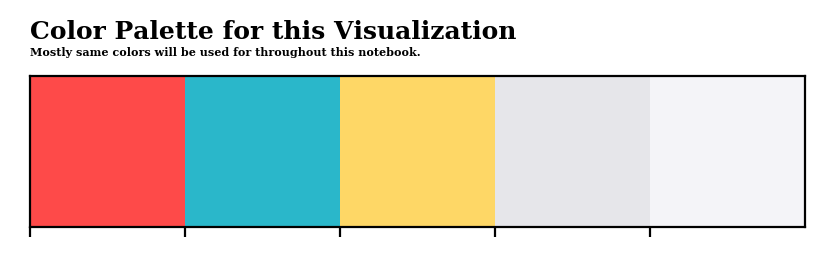

In [6]:
colors= ['#fe4a49' ,'#2ab7ca' ,'#fed766' ,'#e6e6ea' ,'#f4f4f8']

palette = sns.color_palette( palette = colors)

sns.palplot(palette, size =1)
plt.text(-0.50,-0.75,'Color Palette for this Visualization', fontfamily='serif',fontsize=9, fontweight='bold')
plt.text(-0.50,-0.64,'Mostly same colors will be used for throughout this notebook.', fontfamily='serif',fontsize=4, fontweight='bold')
plt.show()

<br><br>

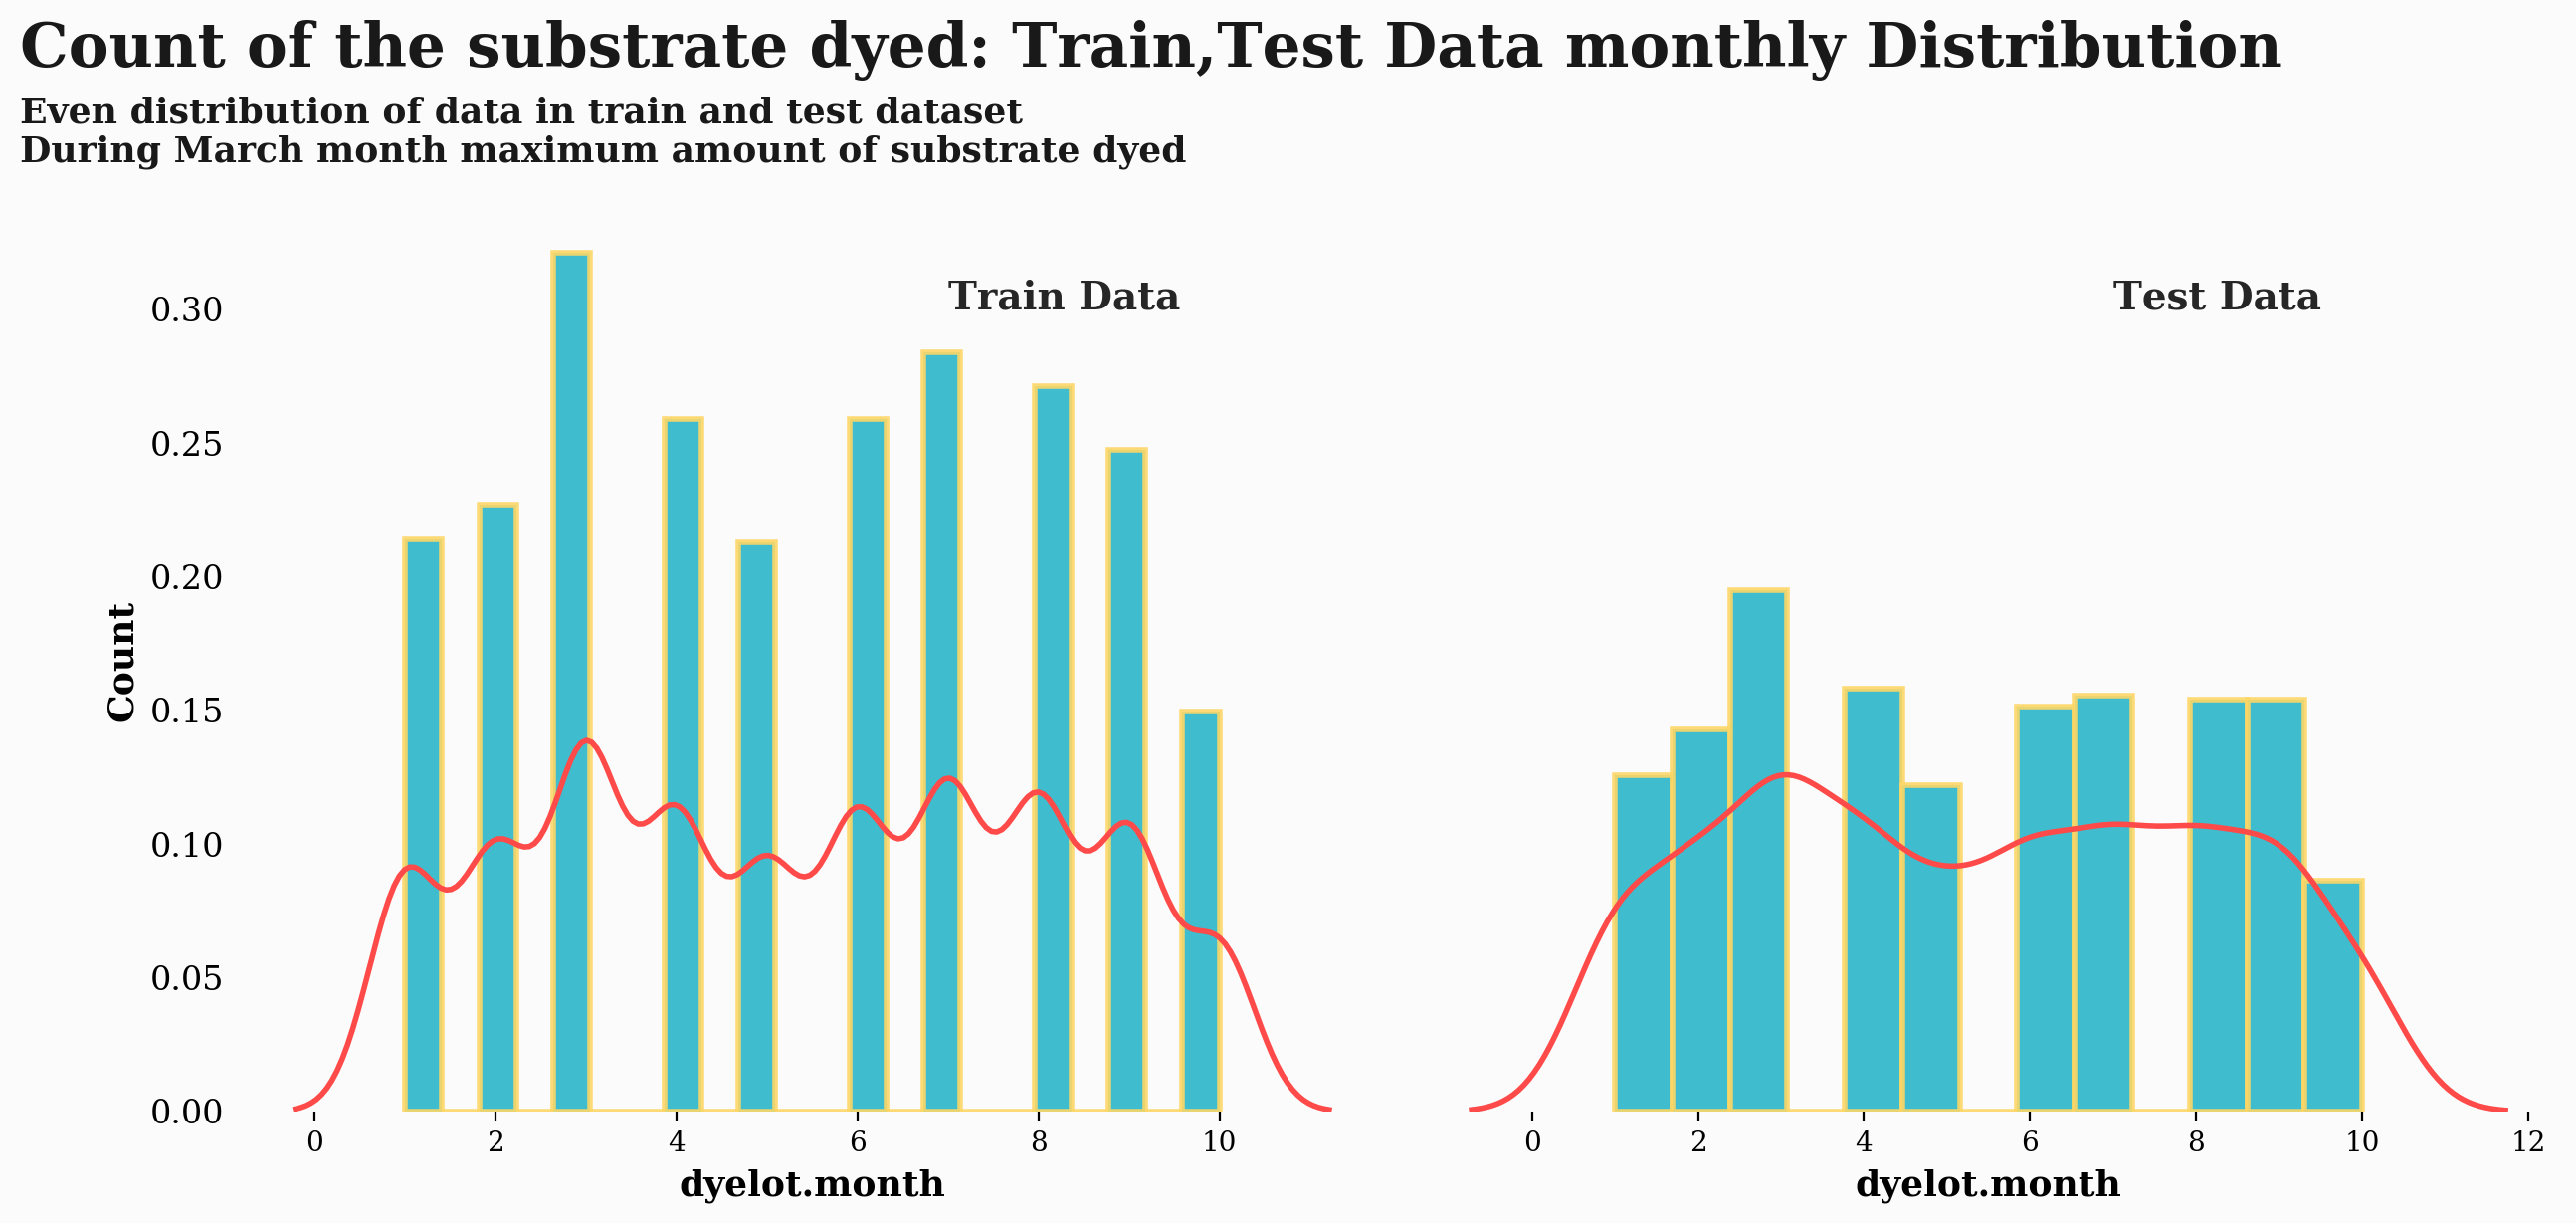

In [7]:
fig = plt.figure(figsize = (15,6))
fig.set_facecolor('#fbfbfb')

gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[:,0:5])
ax1 = fig.add_subplot(gs[:,5:], sharey = ax0)


axes = [ax0,ax1]
for ax in axes:
    ax.set_facecolor('#fbfbfb')
    for loc in ['left','right', 'top','bottom']:
        ax.spines[loc].set_visible(False)

ax0.tick_params(axis='y', which='major', 
                    labelsize=12, labelright =False,left =False,right=False,labelleft=True,rotation = 0)


### plots 
sns.distplot(x = df_train['dyelot.month'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9 },
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax0)
sns.distplot(x = df_test['dyelot.month'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9},
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax1)
ax1.axes.get_yaxis().set_visible(False)
ax0.set_ylabel('Count',fontfamily='serif',fontsize=13,fontweight='bold') 
ax0.set_xlabel('dyelot.month',fontfamily='serif',fontsize=13,fontweight='bold')
ax1.set_xlabel('dyelot.month',fontfamily='serif',fontsize=13,fontweight='bold')


#### final writigs and titles


fig.text(0.05,1,'Count of the substrate dyed: Train,Test Data monthly Distribution ' ,fontfamily='serif',fontsize=22,fontweight='bold', alpha = 0.9)
fig.text(0.05,0.92,'Even distribution of data in train and test dataset \nDuring March month maximum amount of substrate dyed' ,fontfamily='serif',
         fontsize=13,fontweight='bold', alpha = 0.9)

### subplot titles
ax0.text(7,.3, 'Train Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)
ax1.text(7,.3, 'Test Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)

fig.show()
fig.savefig('montly_distribution')

<br><br><br>

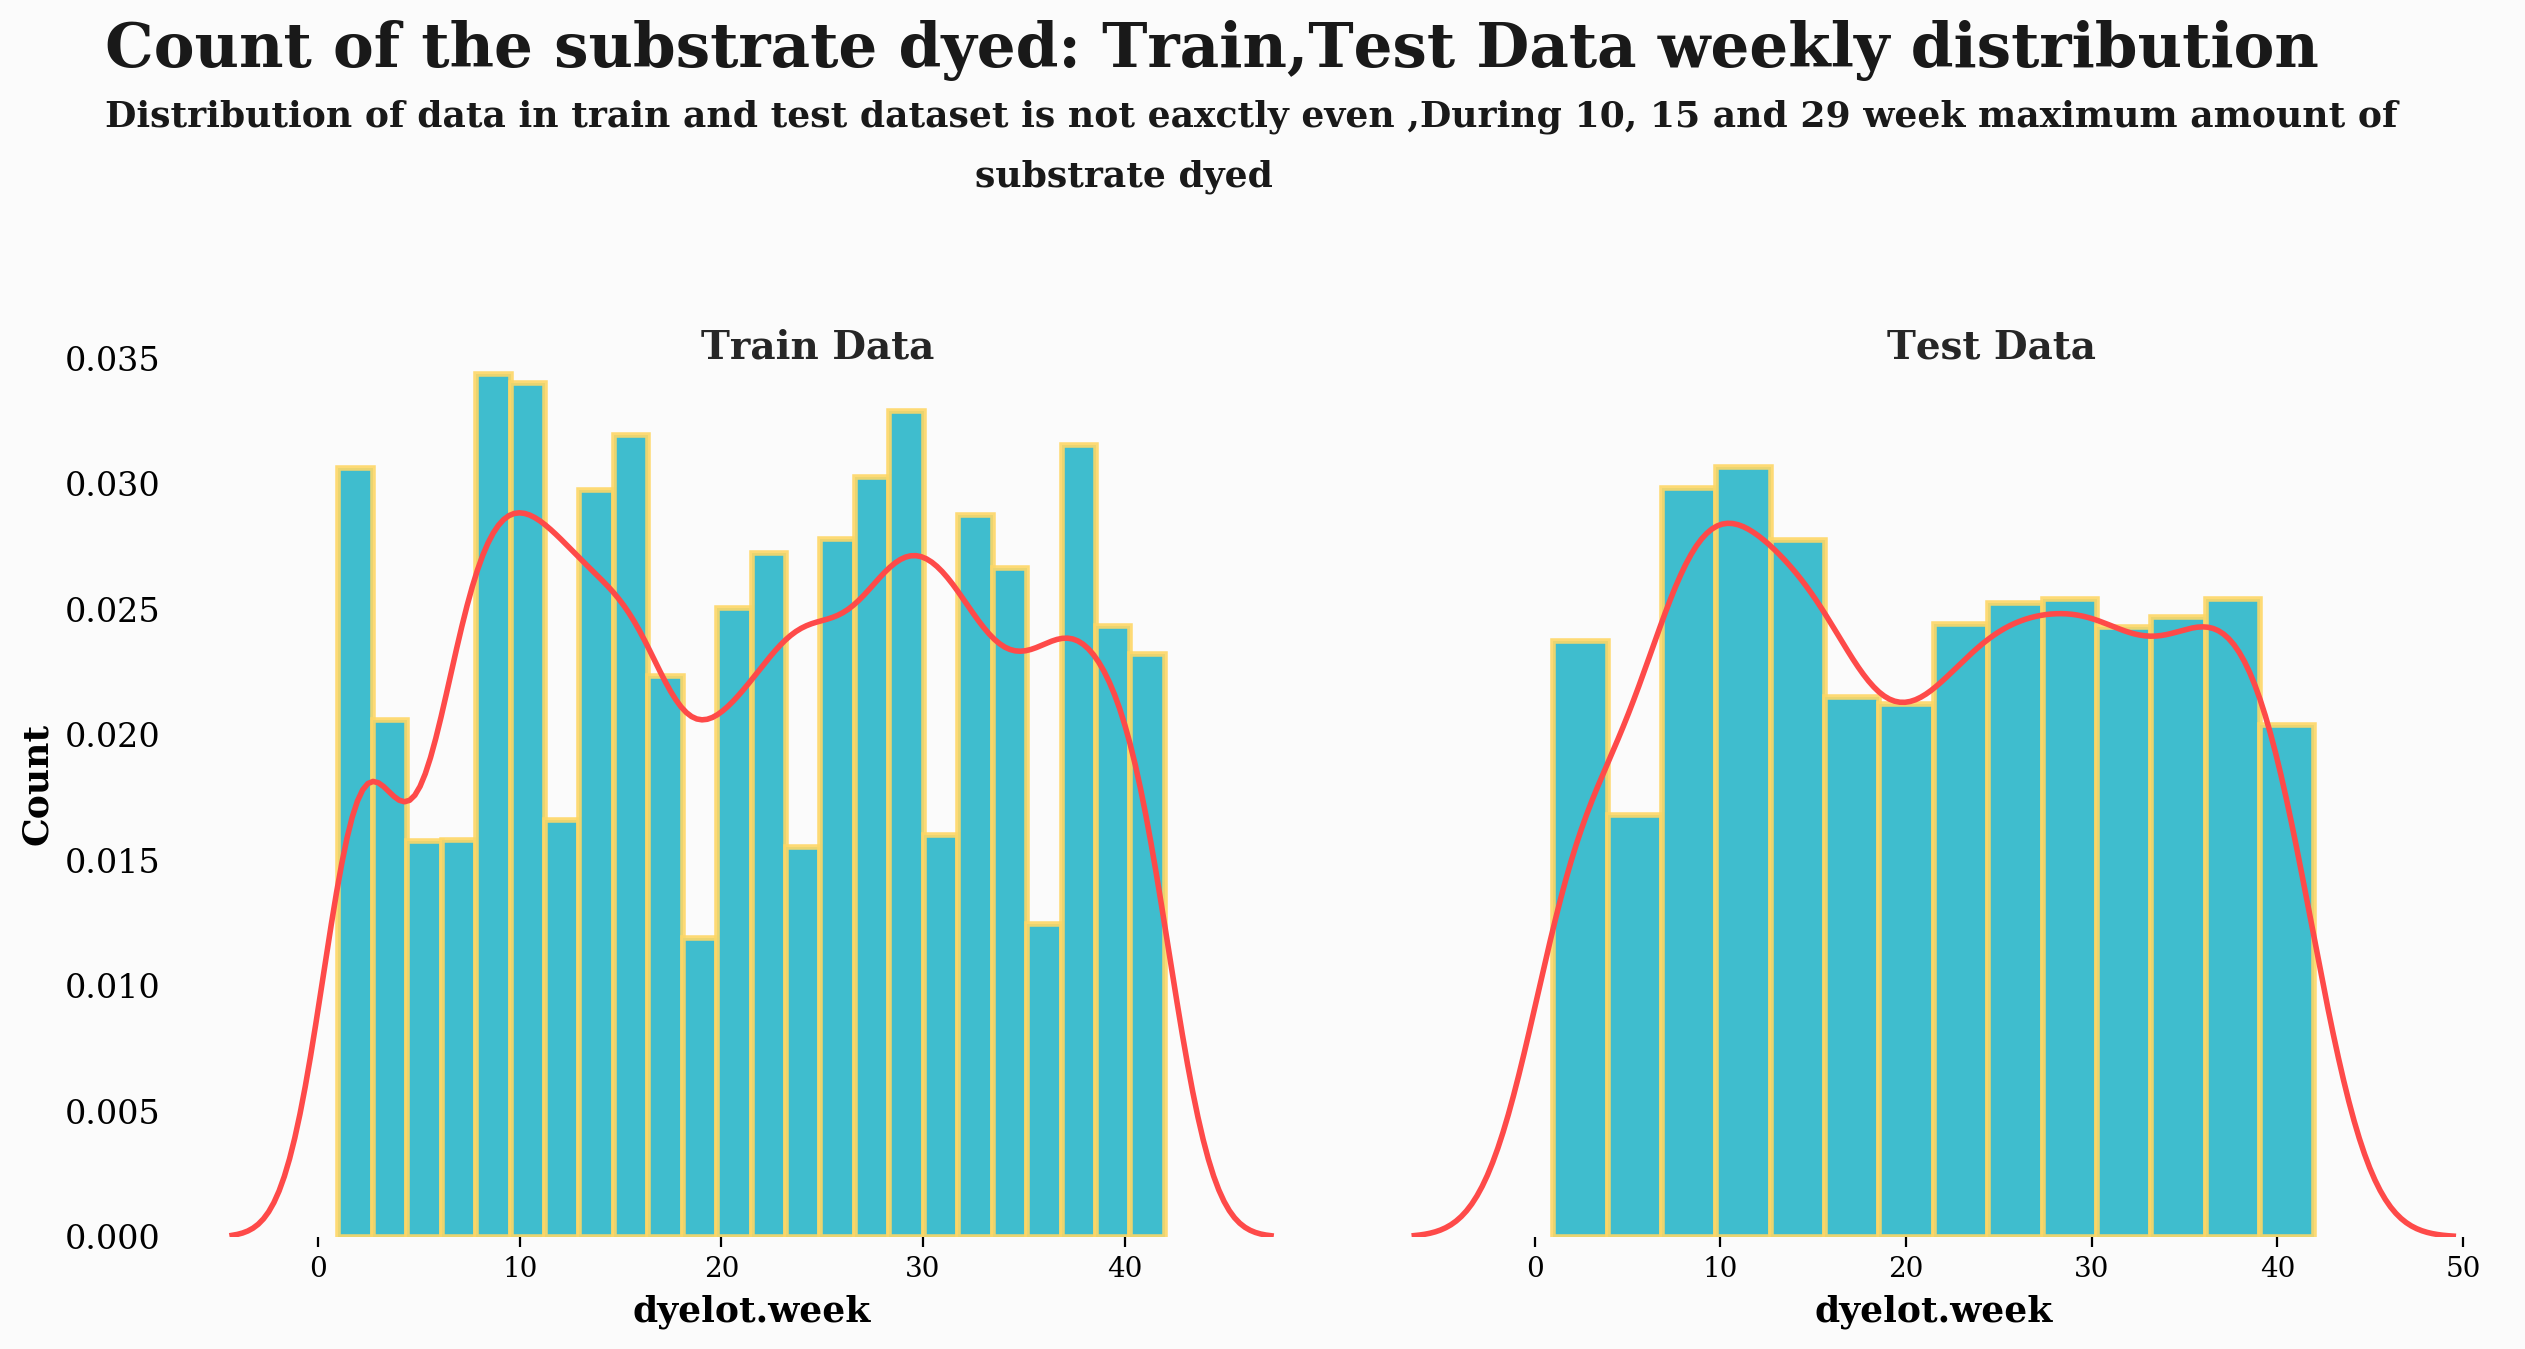

In [8]:
fig = plt.figure(figsize = (15,6))
fig.set_facecolor('#fbfbfb')

gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[:,0:5])
ax1 = fig.add_subplot(gs[:,5:], sharey = ax0)


axes = [ax0,ax1]
for ax in axes:
    ax.set_facecolor('#fbfbfb')
    for loc in ['left','right', 'top','bottom']:
        ax.spines[loc].set_visible(False)

ax0.tick_params(axis='y', which='major', 
                    labelsize=12, labelright =False,left =False,right=False,labelleft=True,rotation = 0)


### plots 
sns.distplot(x = df_train['dyelot.week'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9 },
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax0)
sns.distplot(x = df_test['dyelot.week'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9},
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax1)
ax1.axes.get_yaxis().set_visible(False)
ax0.set_ylabel('Count',fontfamily='serif',fontsize=13,fontweight='bold') 
ax0.set_xlabel('dyelot.week',fontfamily='serif',fontsize=13,fontweight='bold')
ax1.set_xlabel('dyelot.week',fontfamily='serif',fontsize=13,fontweight='bold')


#### final writigs and titles


fig.text(0.1,1.1,'Count of the substrate dyed: Train,Test Data weekly distribution ' ,fontfamily='serif',fontsize=22,fontweight='bold', alpha = 0.9)
fig.text(0.1,1.05,'Distribution of data in train and test dataset is not eaxctly even ,During 10, 15 and 29 week maximum amount of' ,fontfamily='serif',
         fontsize=13,fontweight='bold', alpha = 0.9)
fig.text(0.39,1.0,'substrate dyed' ,fontfamily='serif',
         fontsize=13,fontweight='bold', alpha = 0.9)



### subplot titles
ax0.text(19,.035, 'Train Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)
ax1.text(19,.035, 'Test Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)

fig.show()
fig.savefig('weekly_distribution')

<br><br>

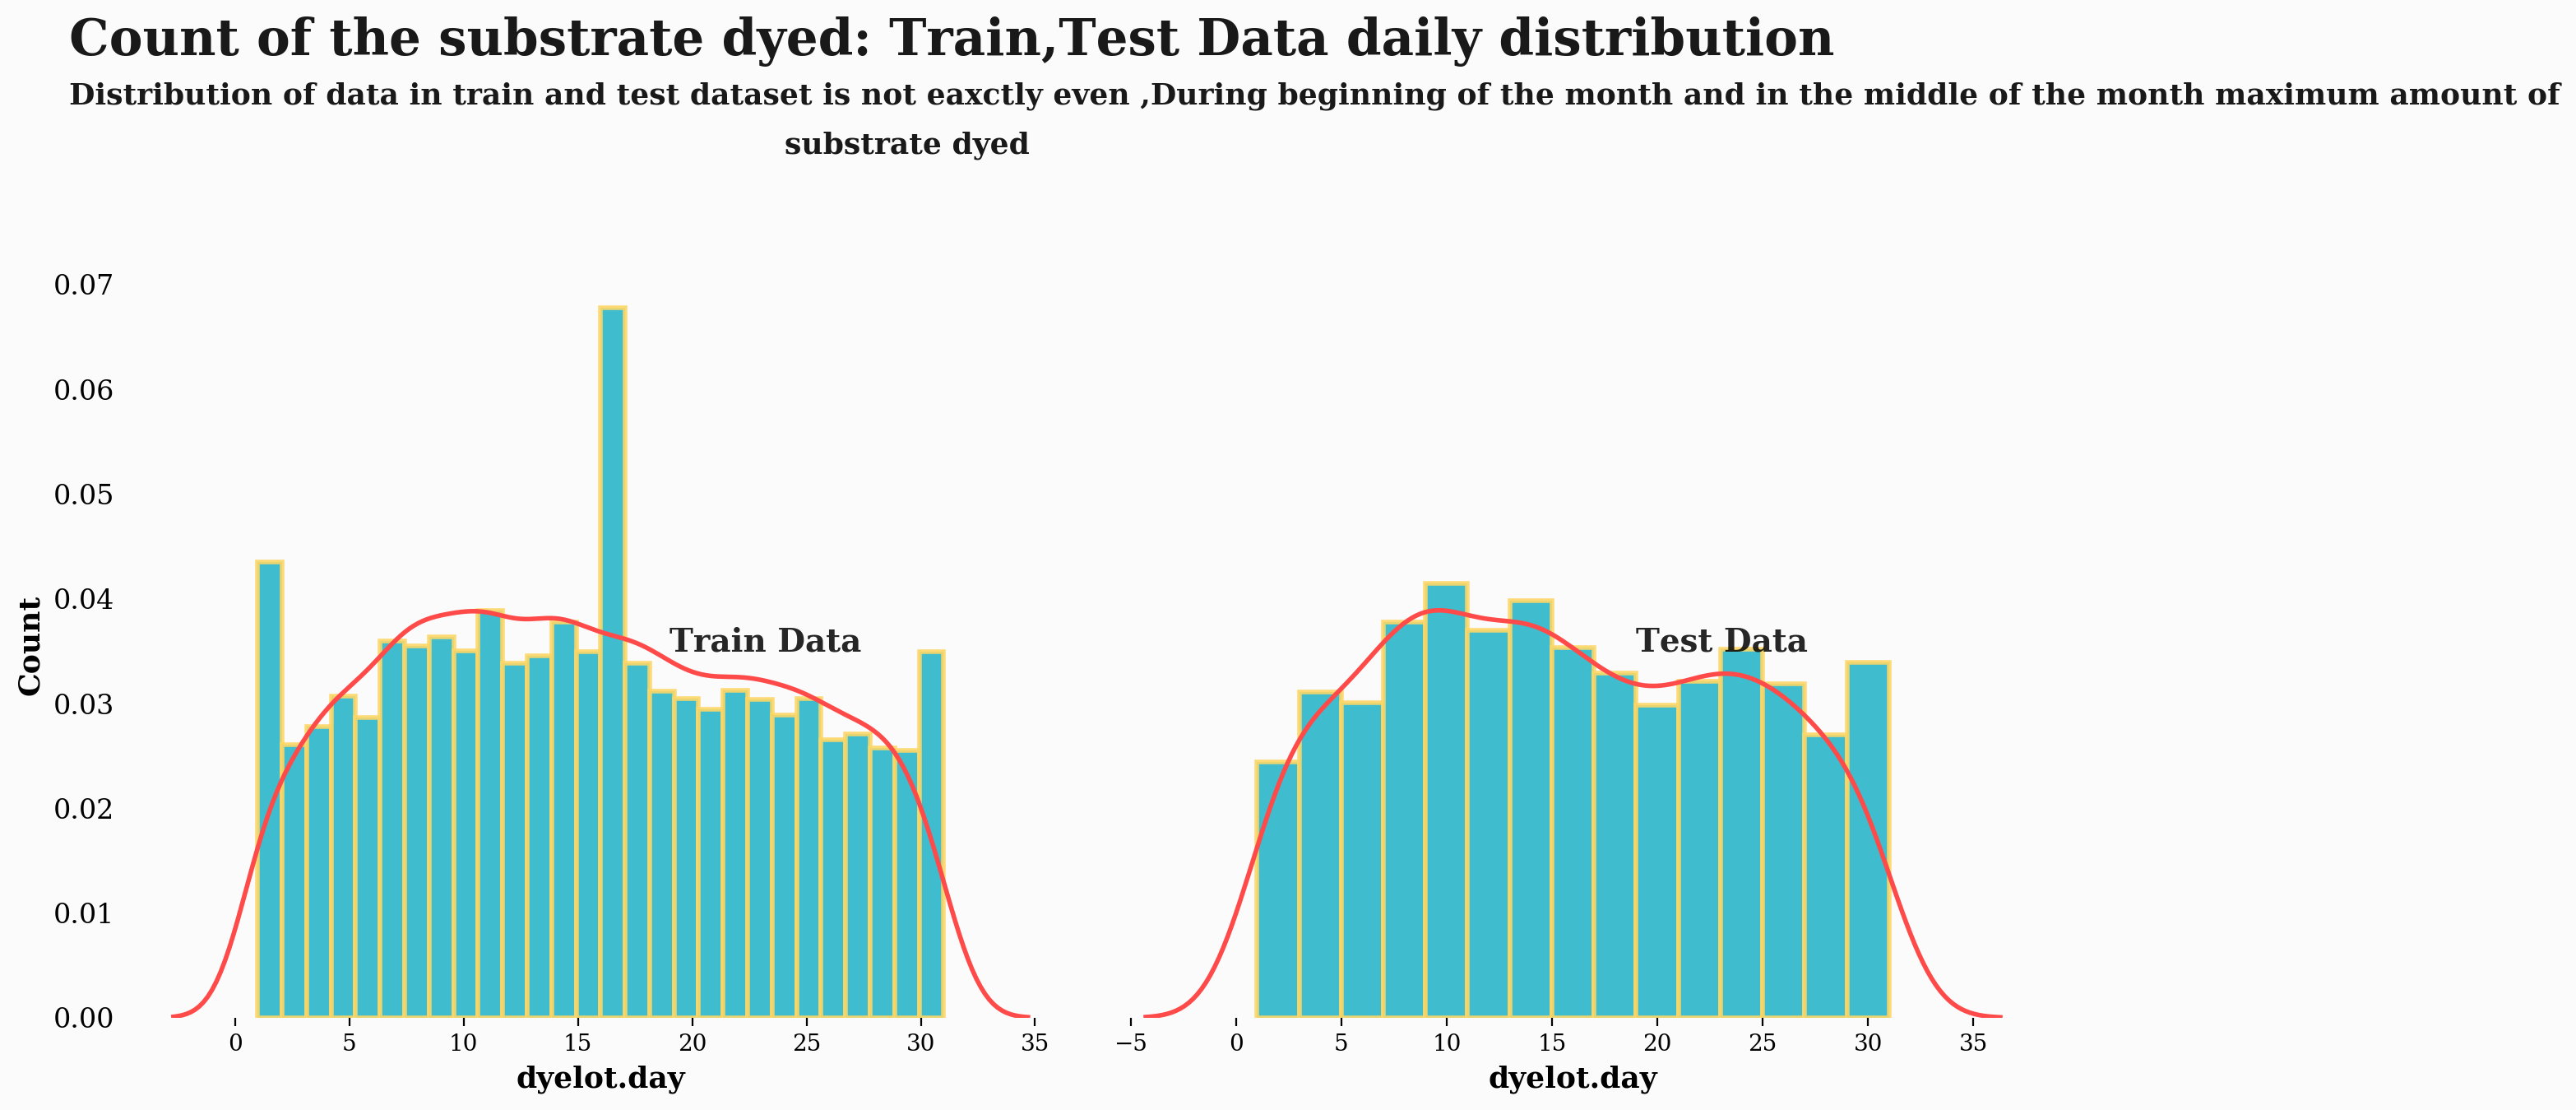

In [9]:
fig = plt.figure(figsize = (15,6))
fig.set_facecolor('#fbfbfb')

gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[:,0:5])
ax1 = fig.add_subplot(gs[:,5:], sharey = ax0)


axes = [ax0,ax1]
for ax in axes:
    ax.set_facecolor('#fbfbfb')
    for loc in ['left','right', 'top','bottom']:
        ax.spines[loc].set_visible(False)

ax0.tick_params(axis='y', which='major', 
                    labelsize=12, labelright =False,left =False,right=False,labelleft=True,rotation = 0)


### plots 
sns.distplot(x = df_train['dyelot.day'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9 },
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax0)
sns.distplot(x = df_test['dyelot.day'],
             hist_kws = {'color':colors[1], 'linewidth': 2,'edgecolor':colors[2], 'alpha':0.9},
             kde = True,kde_kws = {'color':colors[0], "linewidth": 2}, ax=ax1)
ax1.axes.get_yaxis().set_visible(False)
ax0.set_ylabel('Count',fontfamily='serif',fontsize=13,fontweight='bold') 
ax0.set_xlabel('dyelot.day',fontfamily='serif',fontsize=13,fontweight='bold')
ax1.set_xlabel('dyelot.day',fontfamily='serif',fontsize=13,fontweight='bold')


#### final writigs and titles


fig.text(0.1,1.1,'Count of the substrate dyed: Train,Test Data daily distribution ' ,fontfamily='serif',fontsize=22,fontweight='bold', alpha = 0.9)
fig.text(0.1,1.05,'Distribution of data in train and test dataset is not eaxctly even ,During beginning of the month and in the middle of the month maximum amount of' ,fontfamily='serif',
         fontsize=13,fontweight='bold', alpha = 0.9)
fig.text(0.39,1.0,'substrate dyed' ,fontfamily='serif',
         fontsize=13,fontweight='bold', alpha = 0.9)



### subplot titles
ax0.text(19,.035, 'Train Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)
ax1.text(19,.035, 'Test Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.85)

fig.show()
fig.savefig('daily_distribution')

<br><br>

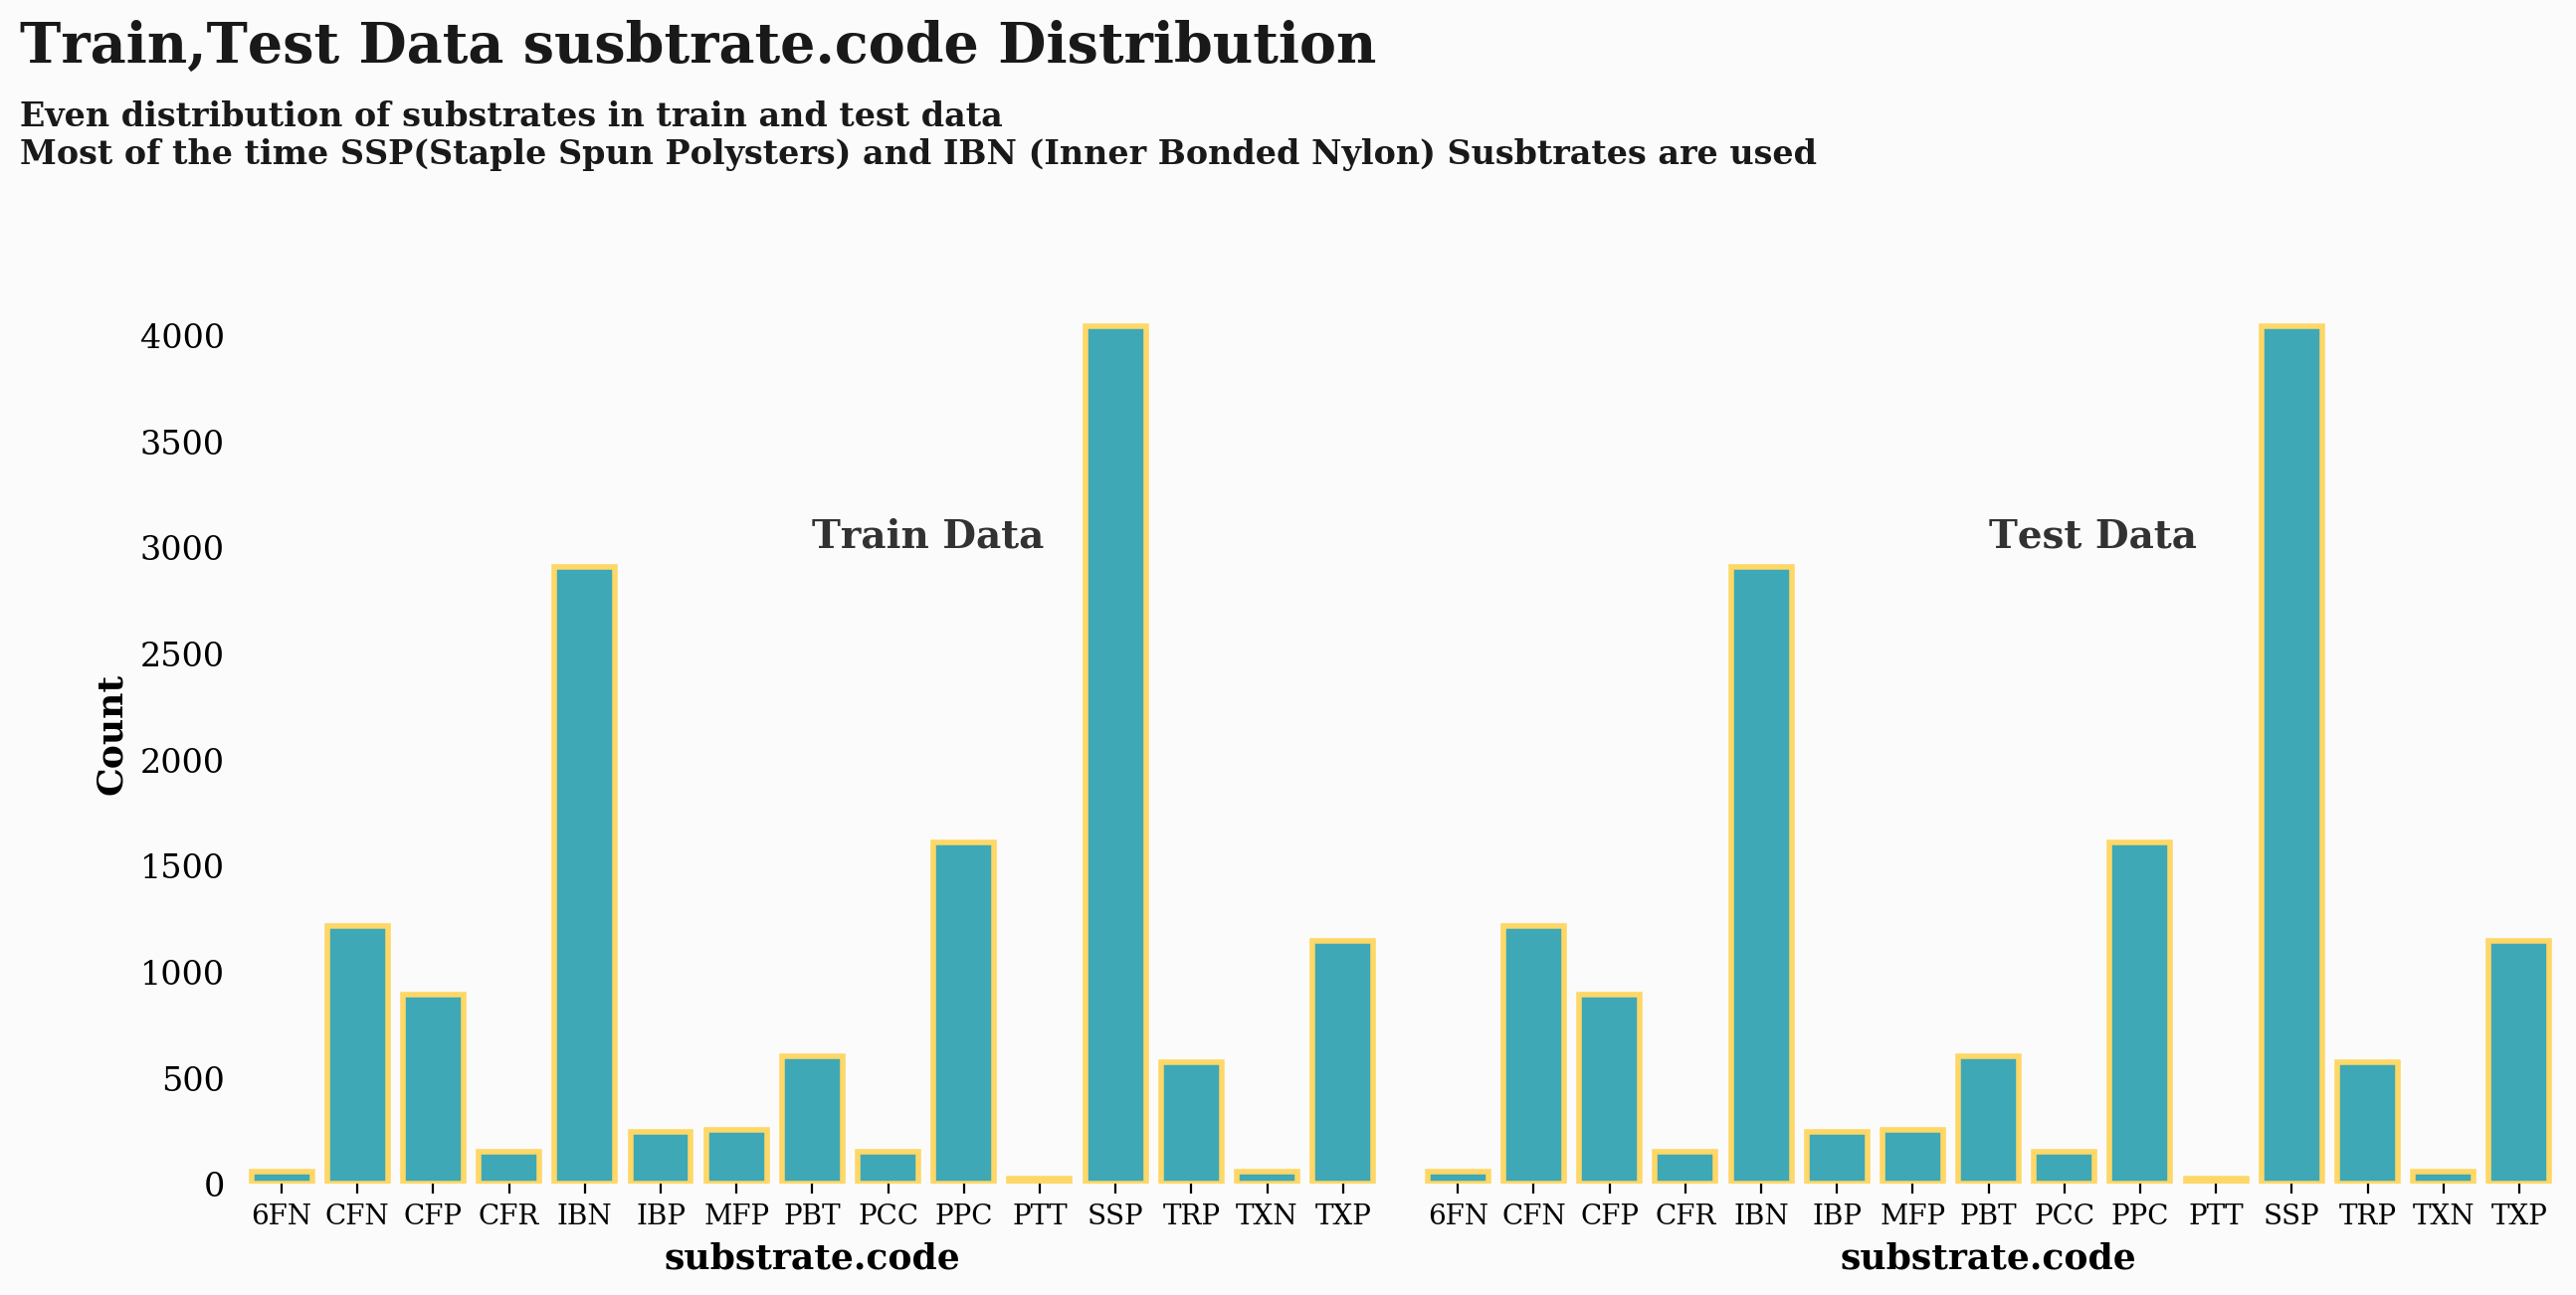

In [10]:
fig = plt.figure(figsize = (15,6))
fig.set_facecolor('#fbfbfb')

gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[:,0:5])
ax1 = fig.add_subplot(gs[:,5:], sharey = ax0)


axes = [ax0,ax1]
for ax in axes:
    ax.set_facecolor('#fbfbfb')
    for loc in ['left','right', 'top','bottom']:
        ax.spines[loc].set_visible(False)

ax0.tick_params(axis='y', which='major', 
                    labelsize=12, labelright =False,left =False,right=False,labelleft=True,rotation = 0)


### plots 

train_date_order = df_train['substrate.code'].sort_values().unique().tolist()
test_date_order = df_train['substrate.code'].sort_values().unique().tolist()

sns.countplot(x = df_train['substrate.code'], ax=ax0,order = train_date_order,
              color = colors[1], edgecolor = colors[2], linewidth =2)
sns.countplot(x = df_train['substrate.code'],ax=ax1,order = test_date_order,
             color = colors[1], edgecolor  = colors[2], linewidth =2)

ax1.axes.get_yaxis().set_visible(False)
ax0.set_ylabel('Count',fontfamily='serif',fontsize=13,fontweight='bold') 
ax0.set_xlabel('substrate.code',fontfamily='serif',fontsize=13,fontweight='bold')
ax1.set_xlabel('substrate.code',fontfamily='serif',fontsize=13,fontweight='bold')


#### final writigs and titles


fig.text(0.05,1.065, 'Train,Test Data susbtrate.code Distribution ' ,fontfamily='serif',fontsize=20,fontweight='bold', alpha = 0.9)
fig.text(0.05,0.98,'Even distribution of substrates in train and test data \nMost of the time SSP(Staple Spun Polysters) and IBN (Inner Bonded Nylon) Susbtrates are used' ,fontfamily='serif',
         fontsize=12,fontweight='bold', alpha = 0.9)

### subplot titles
ax0.text(7,3000, 'Train Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.80)
ax1.text(7,3000, 'Test Data',fontfamily='serif',fontsize=14,fontweight='bold',alpha = 0.80)

fig.show()
fig.savefig('Substratecode_distribution')

<br><br>

### Distribution of the data with the target in the traning dataset
<br><br>

passed
0     2499
1    11435
Name: passed, dtype: int64
13934
passed
0    0.18
1    0.82
Name: passed, dtype: float64
passed     0     1
passed  0.18  0.82
Index(['passed'], dtype='object') passed    0.82
Name: 1, dtype: float64


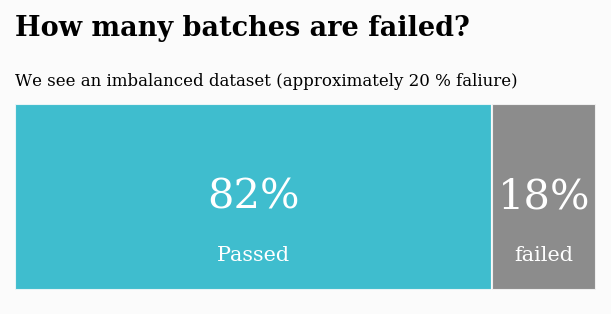

In [14]:
#  Visualisation 


x=df_train.groupby(['passed'])['passed'].count() #groupby target and count all 0 and 1
print(x)
y=len(df_train) #length of the dataframe
print(y)
r=((x/y)).round(2) # %of theeach target present in the data set
print(r)
ratio = pd.DataFrame(r).T #ratio estimated and transposed the table
print(ratio)


fig, ax = plt.subplots(1,1,figsize=(5, 1.8),dpi=150)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 
print(ratio.index, ratio[1.0])



ax.barh(ratio.index, ratio[1.0], color='#2ab7ca', alpha=0.9, ec=background_color, label='passed')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='failed')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Passed", xy=(ratio[1.0][i]/2, -0.25),va = 'center', ha='center',fontsize=10, fontweight='light', fontfamily='serif',color='white')


for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("failed", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),va = 'center', ha='center',fontsize=10, fontweight='light', fontfamily='serif',color='white')
    
    
fig.text(0.125,1.1,'How many batches are failed?', fontfamily='serif',fontsize=13, fontweight='bold')
fig.text(0.125,0.915,'We see an imbalanced dataset (approximately 20 % faliure)',fontfamily='serif',fontsize=8)  

plt.show()

fig.savefig('Baches_failed')


<br><br><br>

#### lets check how many missing values and duplicated rows are present in the data before decoding it. 

<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Data cleaning and Exploring the data </h2>
<br>
<br>

<p style = "font-size:20px"><strong>Handling Missing values and duplicates</strong></p>

<strong>Finding and removing duplicated rows<strong>

In [12]:
print('\n'+'*'*15 + color_class.BOLD_COLOR+ 'Duplicate values'+ color_class.END + '*'*15+'\n' )


print('Any duplicate values in the training data: {}'.format(df_train.duplicated().any()))
print('Total number of duplicate values in the training data: {}'.format(df_train.duplicated().sum()))

print('\n'+'*'*50 + '\n')

def dup_rows_index(df):
  dup = df[df.duplicated()]
  print('\n\nDuplicated index list:',dup[dup == True ].index.tolist())
  return dup
dup_rows_index(df_train)
print('\n'+'*'*50 + '\n')

# Dropping all the duplicate rows and kept first
df_train = df_train.drop_duplicates(subset=['batch.id'], keep='first')

print('Any duplicate rows present: {}'.format(df_train.duplicated().any()))
print('Any duplicate rows present now removed')

print('\n'+'*'*50 + '\n')



***************Duplicate values***************

Any duplicate values in the training data: True
Total number of duplicate values in the training data: 184

**************************************************



Duplicated index list: [20, 70, 71, 84, 165, 187, 658, 726, 790, 811, 880, 953, 988, 1109, 1278, 1283, 1289, 1302, 1329, 1333, 1372, 1424, 1433, 1470, 1521, 1524, 1704, 1713, 1736, 1845, 1889, 1921, 1973, 2011, 2083, 2202, 2317, 2503, 2581, 2604, 2616, 2617, 2826, 3085, 3442, 3447, 3487, 3506, 3746, 3819, 3893, 3957, 4032, 4108, 4262, 4324, 4370, 4397, 4445, 4544, 4565, 4718, 4726, 4829, 4900, 5090, 5116, 5132, 5216, 5293, 5317, 5486, 5535, 5607, 5634, 5725, 5838, 5931, 5935, 5972, 5992, 6019, 6141, 6160, 6164, 6398, 6423, 6424, 6442, 6511, 6630, 6673, 6713, 6759, 6760, 6762, 6819, 7109, 7206, 7236, 7375, 7400, 7448, 7449, 7698, 7711, 7735, 7752, 8052, 8115, 8179, 8223, 8250, 8346, 8350, 8388, 8410, 8553, 8559, 8617, 8671, 8697, 8735, 8958, 9025, 9223, 9451, 9464, 9495, 9528, 95

<br><br>
### Function to print count of missing and zero values in the columns

In [13]:
print('\n'+'*'*15 + color_class.BOLD_COLOR+ 'Missing values table'+ color_class.END + '*'*15+'\n' )



def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Real numbers without Zero Missing Values'] = len(df) -  mz_table['Total Zero Missing Values']
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print('\n'+'*'*50 + '\n')
        print ("Selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        print('\n'+'*'*50 + '\n')
        
        return mz_table

missing_zero_values_table(df_train)


***************Missing values table***************


**************************************************

Selected dataframe has 68 columns and 13750 Rows.
There are 21 columns that have missing values.

**************************************************



,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Real numbers without Zero Missing Values,Data Type
triangle.code.2,0,13623,99.1,13623,99.1,127,object
dye.code.5,0,13600,98.9,13600,98.9,150,float64
dye.code.6,0,13600,98.9,13600,98.9,150,float64
dye.code.4,0,13600,98.9,13600,98.9,150,float64
extra,0,13076,95.1,13076,95.1,674,object
triangle.code.1,0,2320,16.9,2320,16.9,11430,object
machine.manufacturer,0,115,0.8,115,0.8,13635,object
machine.model,0,115,0.8,115,0.8,13635,object
delta.l,69,39,0.3,108,0.8,13642,float64
max.colour.difference,0,39,0.3,39,0.3,13711,float64


<br><br>
### Missing values bar plot

Here for visualisation I am using missigno library bar plot and matrix plot.

Bars are proportional to the number of non-missing values as well as providing the actual number of non-missing values. We get an idea of how much of each column is missing.<br><br>

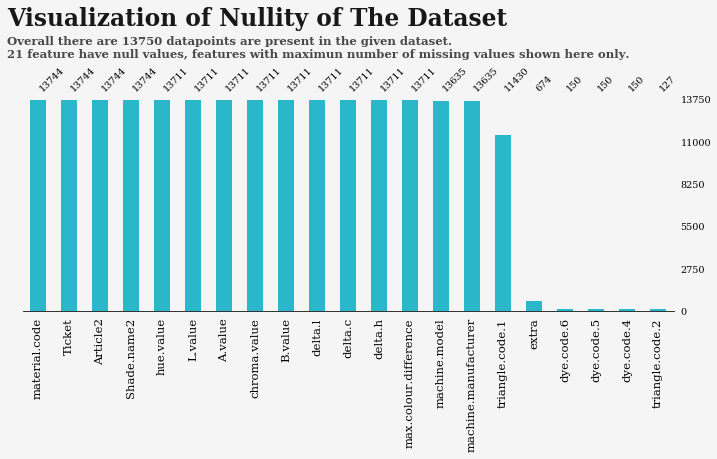

In [14]:
color='#2ab7ca'

fig, ax = plt.subplots(figsize = (12,4), dpi = 70)

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
missing_values = df_train.columns[df_train.isnull().any()].tolist()

                 
msno.bar(df_train[missing_values], sort = 'descending', 
         color = color, 
         ax = ax, fontsize =10,
         labels = 'off',filter = 'top')
                


ax.text(-1,1.35,'Visualization of Nullity of The Dataset',fontsize=24, fontweight='bold', fontfamily='serif', color='black',alpha = 0.9)

ax.text(-1,1.2,'Overall there are 13750 datapoints are present in the given dataset. \n21 feature have null values, features with maximun number of missing values shown here only.',
        fontsize=12, fontweight='bold', fontfamily='serif', color='black', alpha = 0.7)



ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, 
                   ha = 'center', fontsize=12, fontweight='normal', fontfamily='serif', color='black',alpha = 1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)

fig.show()
fig.savefig('nuliity_dataset')


<br><br>
###  msno.matrix for pattern recognition in the missing values

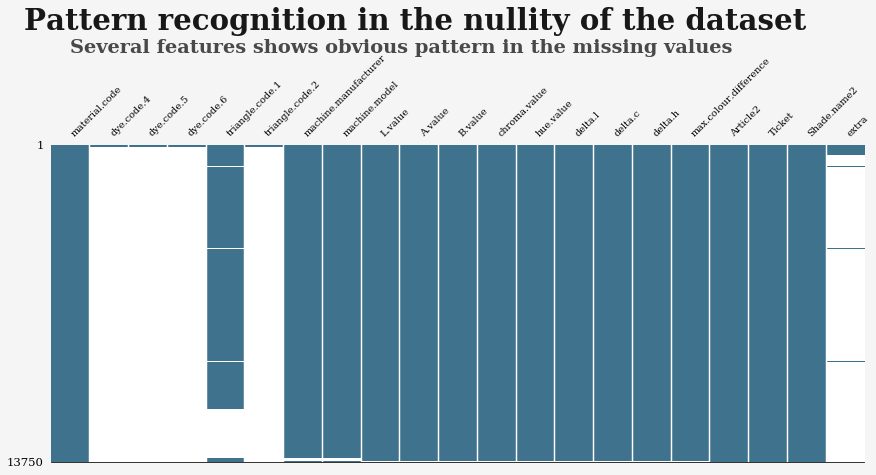

In [15]:

fig, ax = plt.subplots(figsize = (15,6), dpi = 70)

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
missing_values = df_train.columns[df_train.isnull().any()].tolist()

                 
msno.matrix(df_train[missing_values], sort = 'descending', 
         color=(0.25, 0.45, 0.55), 
         ax = ax, fontsize =10,
         labels = 'off',filter = 'top')
                


ax.text(-1.2,-5000,'Pattern recognition in the nullity of the dataset',fontsize=30, fontweight='bold', fontfamily='serif', color='black',alpha = 0.9)

ax.text(0,-4000,'Several features shows obvious pattern in the missing values ',
        fontsize=20, fontweight='bold', fontfamily='serif', color='black', alpha = 0.7)




ax.spines['bottom'].set_visible(True)

<br><br>

### Observations

Since the total number of datapoints is 13934, the columns with lesser than these contain missing values.

Here there is a pattern:
1. The triangle.code.2, dye.code.5, dye.code.6, and dye.code.4 columns seem to have the highest number of missing values.<br>
2. Other than this, on closer observation, you can notice that there are few trends in the missing rows and columns. For example, if a row value is missing from the dye.code5 than there is also the same rows missing from the other dye.code columns.<br>
3. Similar trend observed in delta values, B.value, hue.value, chroma.value and rest other .value columns.<br>
<br>
These trends give an idea about how the features are correlated with one another.
<br>
- It is considered that if there are missing values more than 50 % in a column, it should be removed. So we have removed 5 columns where 95% to 99% values are missing.<br>
- Then the columns where 0.3% to 0.8% values are missing, rows are removed because there is no reason why these values are absent and missing values are very less compared to the total number of data points.<br>
- traingle.code.1 column has 16% values missing. This column contains important information regarding first stage dyeing process and the combination of dyes used. It can not be removed.<br>
<br>
So first removing the rows and columns have more than 50 % data is missing.<br><br><br>

### Handling missing values

In [16]:
#Droping machine. columns missing values
df_train1 = df_train.dropna(subset=['machine.manufacturer', 'L.value', 'material.code'], axis=0)
df_train1 = (df_train1.reset_index()).drop(columns=['index', 'triangle.code.2', 'dye.code.4', 'dye.code.5', 'dye.code.6', 'extra'])
print('\n'+color_class.BOLD_COLOR+ 'Most of the missing values containing rows removed except traingle.code.1 column'+ color_class.END + '\n' )
missing_zero_values_table(df_train1)


Most of the missing values containing rows removed except traingle.code.1 column


**************************************************

Selected dataframe has 63 columns and 13590 Rows.
There are 1 columns that have missing values.

**************************************************



,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Real numbers without Zero Missing Values,Data Type
triangle.code.1,0,2295,16.9,2295,16.9,11295,object



<br><br>
<p style = "font-size:20px"><strong>Statistics of Categorical and Numerical Data....</strong></p>

Now lets dig in to the columns which contains categorical informations and needs decoding.

In [17]:
round (df_train1.describe(exclude = ['float', 'int64']),2)

,dyehouse.code,shade.name,substrate.code,count.ply,fibre.type,recipe.type,unfinished.standard.type,recipe.status,lub.type.name,machine.name,...,machine.model,thread.group,substrate.used.for,Article2,Shade.name2,fibre.char,dyetype,subdetail,shadedepth,supplier
count,13590,13590,13590,13590,13590,13590,13590,13590,13590,13590,...,13590,13590,13590,13590,13590,13590,13590,13590,13590,13590
unique,2,6513,15,83,127,1,127,46,1,272,...,34,109,1,184,6221,54,6,3,5,4
top,VN_HCM,MSCBLACK,SSP,235x3,IBNA02353HH95P,DEFAULT,GCR-SSP,ADJUSTED 30%,NONE,DYE010_C,...,SP 110S/4P,IBN 235X3 INVISTA (CHINA),T,8754,BLACK,3D,E,N,P,G
freq,11374,110,3859,1595,1495,13590,1367,1526,13590,127,...,2720,1374,13590,1942,177,2043,4929,10555,4619,10530


<br><br>
###  Observations :

Now we Know which columns contains categorical information and we can start looking one by one to decode these columns. 

- From above stattistics, I found that certain columns contains only one category, So these columns need to be removed. [recipe.type, recipe.type.code, dyelot.year, lub.type.name , substrate.used.for]

<br><br>

In [18]:
df_train2 = df_train1.drop(['recipe.type', 'recipe.type.code', 'dyelot.year','lub.type.name', 'substrate.used.for', 'dyelot.date'], axis='columns')
df_train2 = (df_train2.reset_index()).drop(columns='index')
print('\n'+color_class.BOLD_COLOR+ 'Columns with one category are removed'+ color_class.END + '\n' )


Columns with one category are removed



### Decoding columns

<strong>Now question is how to decode the coded? <strong>

### dyehouse.code	
Code representing the individual site. It has binary categories are present.

### Shade.name2 : 037UR, C7503, 80922
- We can not split the shade column with any logic for a moment we wil have to consider it as combine one category because it can not be saparated not on the basis of alphabets or number no trend.
- there are almost 6000 shades category present we will have to cosider it like as it is one category of shade.
- shade.name contains the same information so can be removed thoughi can see there are some initials like COM + 0301F, EUR + 08529 attached to shade name but I did not find any reasonable logic and domain information with which I can saparate this code. So I prefer to remove this information.
- Though initials contains EUR, V and GCR could be currency, country or continent name in front of it. 
- I found this information prent in unfinished type data so preferred to removed shade.name.

### substrate.code : PPC, SSP
- represents the name of the material used like SSP stands for staple spun polyster.
- There are almost 15 substrates oresnet so will use it as individual category

### Countply: 125 x 2 (yarns count x ply)

- Count.ply has all the digits so splitted into 2 columns count and ply
- count is in the unit dtex and ply is twisting of the fibre.
- total thread size can be estimated by the count ply by myltplying count and ply.
dtex(count) * ply = resultant thread size(in dtex unit)
- dtex gives weight in grams of per 10,000 meters of thread length.
- So here thread.size.weightdtex column gives thread size in weights which is gm/10,000 meters.
- In fixed length systems:  As the yarn count number increase,  it becomes coarser and heavier.
for example
  dtex       heaviness
   200       lighter, low density
   234       heavier, higher density
   
   
### fibre.type : PPCA01252TD95R = PPC + A + 01252 + T + D + 9 + 5 + R

- Lets split one by one AAA+T+CCCCC+ F+S+K+T+B
- PPC (AAA) substrate code which information we already have so we can remove this after splitting.
- A (T)It is an additional attribute which is unknown.
-  01252 (CCCCC): Sizing & Plies (dtex+plies)This column can be also remove dbecause it contains count x ply column information.
- T (F): filament supplier information not relavent at this moment so after splitting can be also removed.
fibre.char also contains this information related to filament supplier.
- D (S): staple supplier this column can be also removed
- 9 (K): package weight There is already one column pacake weight present so this infomation can be also removed.
- 5 (T):Dye center
- R (B):package build
All this inforamtion is already present in the other columns so this column can be removed.


### unfinished.standard.type: GCR-SSP, POLYESTER-CFP'
- This code is saparated by dash.
- spliited in to columns
- SSP This is same information as substrate code so this column can be removed only first column is kept
-  EUR, V and GCR could be currency, country or continent name in front of it. 
- Or can contains information  which type of material or substrate like in this code .POLYESTER-CFP
- So only column ('unfinished_alpha1'column) which contain 1st code is kept.



### Article2: UI09, 1422, SZRL
- Again here this column is like shade.name column. There is no proper logic to saparate this in form of digit and numbers.
- It is a four digit code code so one thing we can do, consider whole code like a single category or saparte every digit and code in four different columns. 
- OR consider it as a single column.
- I found considering this column as a single column much more approriate.
- There will be 182 categories present in this column.



### triangle.code.1: GD16SN =GD + 16 + SN
- splitted the triangle.code.1 column in 3 columns 1:'trianglecode.alphabet', 2:'trianglecode.digit', 3:'trianglecode.N'
- These columns contain dye related information.
- Replace all the nan and '' values from zero, as we can not remove this column or rows in it and subtitute with any other relavent information.


   
### Dyeclasses

Dyeclasses : PPCEPPG = PPC(susbtrate code)+E(dyetype)+P(subdetail)+P(shadedepth)+G(supplier)  
- Information relating to the recipe being used to dye this colour on this thread. 
- Its combination of  substrate.code(substrate being dyed), 'dyetype', 'subdetail', 'shadedepth', 'supplier'
- These columns are already present saparately so in combination dye class giving same information
- Therefore dyeclass column is removed.


### fibrechar: 3U, 2P, 30
- Here also you can not saparate it.No logic for for the numbers, sometimes it is digit or sometimes alphabets. It contains fibre related information so I am keeping it without splittimg in to  further characters.
- There are 54 categories present in this column.

### material.code : 2994120-037UR	 = 2994 + 120 + 037UR	
It is combinaton of article, ticket and shade.name so material.code is also removed


### thread.group: CFP-ZNG-M', CFP-74X2-ZHONGTAI (FE)'

- This column contains information like substrate code, country names like india, china and korean cities.
- So first column with susbtrate code is removed and the information related to country is used.
- This column was very difficult to saparate. In this column information is entered very roughly. 
- Sometimes the data is entered like this 'J)TAICANG(YZ' So I had to enter in proper format ('TAICANG(YZ)') and corrected in the whole column.
<br><br><br>


In [19]:
#triangle.code.1 column, 'trianglecode.N' deleted and splitted into 2 columns
trianglecode = df_train2['triangle.code.1'].str.split('([A-Za-z]+)(\d+)', expand=True)
trianglecode = trianglecode.loc[:,[1,2,3]]
trianglecode.rename(columns={1:'trianglecode.alphabet', 2:'trianglecode.digit', 3:'trianglecode.N'}, inplace=True)
trianglecode = (trianglecode[['trianglecode.alphabet', 'trianglecode.digit', 'trianglecode.N']].fillna('0')).replace('', '0')


#countply column
countply = df_train2['count.ply'].str.split('(\d+)', expand=True)
countply = countply.loc[:,[1,2,3]]
countply.rename(columns={1:'count.dtex', 2:'x', 3:'ply'}, inplace=True)
countply = countply.astype({"count.dtex":'float', "ply":'float'})#But the count and ply column is object need to convert object to float
countply['thread.size.weightdtex'] = countply ['count.dtex'] * countply ['ply'] #In order to get the resultant thread size we will have to multiply the yarn count with ply.

#unfinished.standard.type split into three columns alpha 1 has information but rest 2 are substrate code and no new information so removed
unifinished_standard_type = df_train2['unfinished.standard.type'].str.split(pat = '-', expand=True).rename(columns={0:'unfinished_alpha1', 1:'unfinished_alpha2', 2:'unfinished_alpha3'}).fillna('0')
unifinished_standard_type = unifinished_standard_type.drop(columns = ['unfinished_alpha2', 'unfinished_alpha3'])
unifinished_standard_type



#Thread.group column is splitted into the thread_group_country
thread_group = df_train2['thread.group'].str.split(pat = '-', expand=True).rename(columns={0:'substrate', 1:'thread_group1', 2:'thread_group_country', 3:'z'})
replace_substrate = {'CFP': '', 'IBP': '', 'IBN':'', 'PPC':'', 'SSP':'', 'TXP 2':'', 'TXP 1':'', 'SSP FINE':'',
       'SSP MEDIUM': '', 'MFP': '', 'CFPB': '', 'HTXP': '', 'PPC UPP': '',
       'IBN 235X3 INVISTA (CHINA)': 'INVISTA (CHINA)', '700X1 HYOSUNG': 'HYOSUNG', 'SSP 130x2 YZ': 'YZ',
       'TXP': '', 'CFN': '', 'CFR': '', 'PTT': '', 'TRP': '', 'CFP MED (ZHONGTAI ': 'ZHONGTAI',
       'PCC 490X2 ZHONGTAI': 'ZHONGTAI', 'PPC 365X2 ZHONGTAI (NM)':'ZHONGTAI (NM)', 'CFP ': '',
       'MFP FINE ': '', 'SSPC': '', 'TXN': '', 'PCC 1100X2': '', 'TXP 110/2': '',
       'PBT 370X2 GLOBAL': 'GLOBAL', 'CFP 138/3': '', '400X4': '', '940X1 HYOSUNG':'HYOSUNG' ,
       'TRP SYL_AR': '', 'SSP VERY COARSE (T393)': '', '6FN FINE': '', 'PPC 365X2 ': '',
       'PCC FINE (TEIJIN +DCH)':'TEIJIN +DCH' , '484X2 ZHONGTAI': 'ZHONGTAI', 'SSP 394X3 R52': '',
       'IBP COURSE (WESTER)': 'WESTER', 'CFN FINE': '', 'PCC COARSE (HYOSUNG + DCH)': 'HYOSUNG+DCH',
       'CFP COARSE (ZHONGTAI INDO)': 'ZHONGTAI INDO', 'CFP 112X3 ZHONGTAI (INDO ': 'ZHONGTAI (INDO)',
       'CFN 110X2 (SHENMA)': 'SHENMA', 'SSPC MED (GCY)': '',
       'PCC MEDIUM (HYOSUNG + DCH)': 'HYOSUNG+DCH', 'PBT': '', 'PPCV COARSE': '',
       'PPC UPP_MISCO T333': '', 'CFN 700X3 HYOSUNG':'HYOSUNG' , 'PBT 167X2 TASDELEN': 'TASDELEN',
       'PCC VCOARSE (HYOSUNG+DCH)': 'HYOSUNG+DCH', 'CFP 660/3':'', 'PCC FINE':'', 'CFN VCOARS': '',
                    'J)TAICANG(YZ': 'TAICANG(YZ)' }
replace_thread_group_country = {'M' : '', 'C' : '', 'F' : '', 'None' : '', 'T393' : '', 'SHENMA (HIGH TWIST)':'SHENMA',
                                'G82 (MICRO)': '', '303K' : '', 'Micro' : '', 'VERY COARSE' :'', 'DCH' : '',
                                'COARSE': '', 'DCH)':'', 'J)TAICANG(YZ': 'TAICANG(YZ)',
                            'TAICANG (YZ': 'TAICANG (YZ)', 'TEIJIN (MICRO)': 'TEIJIN'}
replace_thread_group1 = {'235X3' : '', 'FINE': '', 'None': '', 'COARSE COUNT': '', '484X2': '', 'MEDIUM': '', '312X3' : '', '470X3' : '', '125X2': '', '130X2' : '', 
                         'COARSE': '', '8G/D': '', '7G/D': '','87X2': '', '110X2':'' , 'R52': '', 'MISCO T333': '', 'NEW' : '', 
                         'Fine': '', '205X2 ZHONGTAI (NEW MERGE)': 'ZHONGTAI', 'MED' : '',  'ZNG': 'ZHONGTAI', '235X2': '',
                         'JIPO': '', 'FINE ': '', '83X3': '', ' DCH': '', '74X3': '',  '1670X3': '', '57X3': '', 'GCY': '', 'G2': '', 
                         '74X2': '', 'G3': '', '167X2': '', 'S': '', '455x3': '', ' NEW LOT)': '', 'VCOARSE (UNIFULL)' : '', '470x1': '',
                         '235x2': '', '226x3': '', ' 550X3 ': '', '95x3': '', '138x3': '', '303K': '', '660X3': '', '830x3': '', '133X3': '', 
                         '1400x3': '', "S (PERF']": '', "'S (PERF']": '',' VCOARSE (UNIFULL)': '', 'J)TAICANG(YZ': 'TAICANG(YZ)' }
thread_group = thread_group.replace({'substrate':replace_substrate, "thread_group_country": replace_thread_group_country, "thread_group1": replace_thread_group1 })
thread_group['thread_group_country'] = thread_group['substrate'] + thread_group['thread_group_country'] + thread_group['thread_group1']
thread_group = thread_group.replace({'thread_group_country': {'J)TAICANG(YZ': 'TAICANG (YZ)', 'ZHONGTAI (FE)57X2': 'ZHONGTAI(FE)', 'LOCAL ' : 'LOCAL'}  })
thread_group = thread_group.fillna('0').replace('', '0')
thread_group = thread_group.drop(columns = ['substrate', 'thread_group1', 'z'])


#Concating all the decoded columns
df_train2 = pd.concat([df_train2, trianglecode, countply, unifinished_standard_type, thread_group], axis=1).drop(columns=['triangle.code.1', 'trianglecode.N', 'x',
            'count.ply', 'dyeclasses', 'A.value', 'B.value','shade.name', 'material.code', 'unfinished.standard.type','fibre.type', 'thread.group'])
df_train2 = df_train2.reset_index().drop(columns=['index'])

#### Here now after decoding the data from certain columns next question is further investigations on the numerical data.


<br><br>
<p style = "font-size:20px"><strong>Statistics of Numerical Data....</strong></p>

In [20]:
round (df_train2.describe(exclude = 'object'), 2)

,parent.batch.id,dyelot.month,dyelot.week,dyelot.day,batch.id,dyeing.method,machine.volume,total.no.of.cheeses,total.batch.weight,thread.quality,...,hue.value,delta.l,delta.c,delta.h,max.colour.difference,Ticket,passed,count.dtex,ply,thread.size.weightdtex
count,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,...,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00,13590.00
mean,7242910.97,5.42,21.69,15.53,7245535.60,936.72,97.98,14.54,14.00,1.05,...,171.02,0.46,0.27,-0.05,1.82,84.72,0.82,234.41,2.49,610.41
std,2111347.37,2.71,11.78,8.29,2111616.19,1682.93,209.34,36.13,35.68,0.23,...,111.54,2.28,1.79,1.96,3.03,55.82,0.38,200.84,0.97,632.58
min,2366077.00,1.00,1.00,1.00,2366842.00,2.00,1.80,0.00,0.16,1.00,...,0.09,-4.93,-14.98,-57.61,0.02,6.00,0.00,20.00,1.00,60.00
25%,7874538.25,3.00,11.00,9.00,7877477.25,116.00,9.00,1.00,1.00,1.00,...,60.35,-0.23,-0.36,-0.89,1.14,40.00,1.00,125.00,2.00,260.00
50%,8099565.50,6.00,22.00,15.00,8102325.00,311.00,22.50,3.00,3.00,1.00,...,185.64,0.22,0.16,-0.05,1.57,80.00,1.00,167.00,2.00,390.00
75%,8315788.75,8.00,32.00,22.00,8318794.50,888.00,95.00,12.00,11.05,1.00,...,272.90,0.79,0.84,0.79,1.90,120.00,1.00,275.00,3.00,705.00
max,8531240.00,10.00,42.00,31.00,8532154.00,9662.00,2260.00,410.00,410.00,2.00,...,359.99,67.41,75.24,68.95,92.10,991.00,1.00,1670.00,9.00,5010.00


### Observations: 

1. There are 3 different columns representing the weights: total.batch.weight, total.dye.conc.stage.1 and weight.of.stage.1.dye.dispense..g.
2. The corresponding weight ranges are shown in these columns as follows: 'batch.weight.band', 'stage.1.dye.conc.band', 'stage.1.dispense.wt.band'.
3. In principle the band columns and the wight columns provides the same informations. So we will remove .band columns.
4. Here for the ease I am making bins of the weight columns, Which will categorize the batches in cetain weight range.It will help in understanding the data and for future predictions also.


Before binning the data lets check visualise how the data distributed.


<br><br>
### Univariant analysis of Features

Lets Visualise all the numerical data

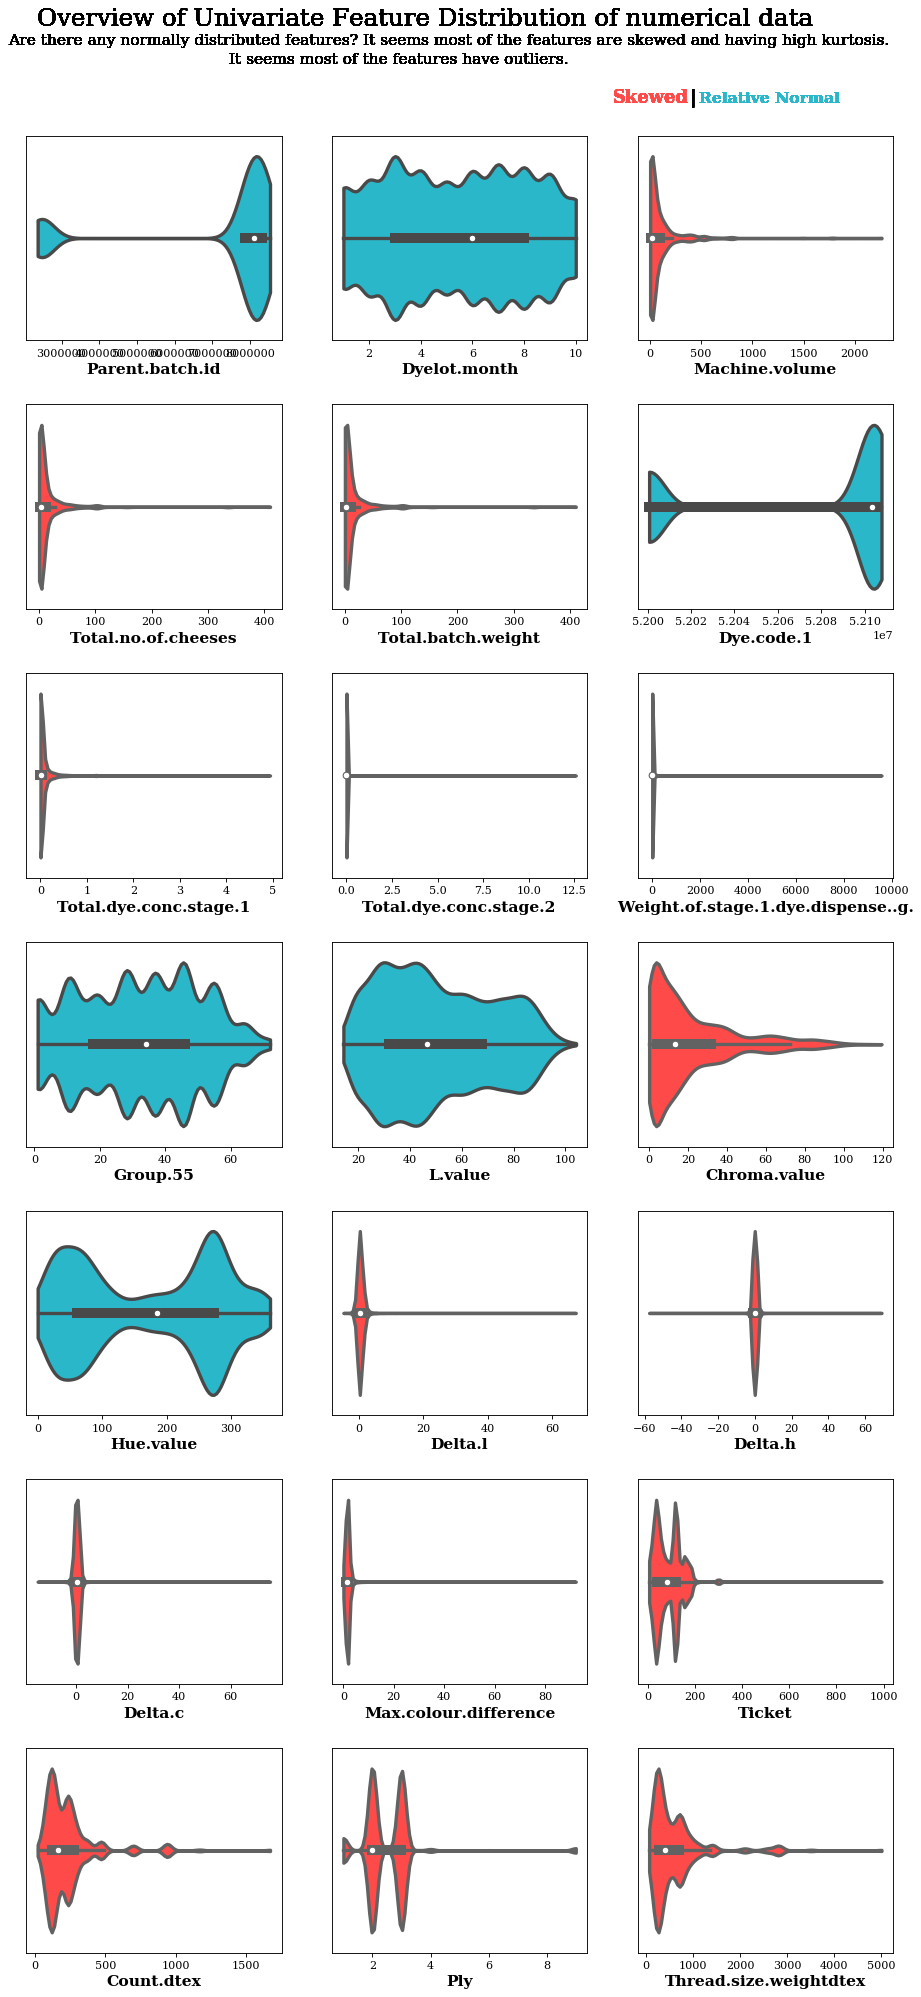

In [21]:
numeric_columns = df_train2[['parent.batch.id','dyelot.month','machine.volume', 'total.no.of.cheeses', 'total.batch.weight', 
         'dye.code.1','total.dye.conc.stage.1','total.dye.conc.stage.2',
          'weight.of.stage.1.dye.dispense..g.', 'group.55', 'L.value','chroma.value','hue.value', 'delta.l',
          'delta.h', 'delta.c', 'max.colour.difference', 'Ticket','count.dtex', 'ply', 'thread.size.weightdtex' ]]

fig,ax = plt.subplots(nrows = 7, ncols = 3, figsize = (12,24),dpi=80)
#fig.patch.set_facecolor(colors[-1])
axes = ax.ravel()

df = numeric_columns

for col,ax in zip(df.columns,axes):
    
    # skewness and kurtosis
    if skew(df[col])>1:
        color = colors[0]
    else:
        color = colors[1]
        
        
    #Plots
    sns.violinplot(df[col], ax =ax, 
                   color = color, cut =0,
                   inner = 'box',
                   alpha = 1,linewidth = 3, edgecolor = 'solidblack', saturation =1 )
    
    
    ## plot setting
    xlabel = ' '.join([value.capitalize() for value in str(col).split('_') ])
    #ax.set_facecolor(colors[-1])
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xlabel(xlabel,fontfamily='serif',fontsize=14,fontweight='bold', alpha = 1)
    
    plt.tight_layout(pad= 3,h_pad = 2.5, w_pad = 2.5)
    
    
    # titles and text
    fig.text(0.05,1.04,'Overview of Univariate Feature Distribution of numerical data', fontfamily='serif',fontsize=22,fontweight='normal', alpha = 1)
    fig.text(0.02,1.03,'''Are there any normally distributed features? It seems most of the features are skewed and having high kurtosis.''',fontfamily='serif',fontsize=14,fontweight='normal', alpha = 1)
    fig.text(0.25,1.02,'''It seems most of the features have outliers.''',fontfamily='serif',fontsize=14,fontweight='normal', alpha = 1)
    
    fig.text(0.65,1, "Skewed",fontfamily='serif',fontsize=16,fontweight='bold', color=colors[0])
    fig.text(0.73,1, '|',fontfamily='serif',fontsize=16,fontweight='bold')
    fig.text(0.74,1, "Relative Normal",fontfamily='serif',fontsize=14,fontweight='bold', color=colors[1])

    

    fig.show()
    fig.savefig('without_outlier removal')


In [25]:
Outlier = df_train2[(np.abs(stats.zscore(df_train2[['max.colour.difference' ]])) < 1).all(axis=1)]

<br><br>

<p style = "font-size:20px"><strong>Outliers detection and removal (Z-score method)</strong></p>

Lets use z score to remove the outlier using z score value 3.

In [25]:
Outlier_removed = df_train2[(np.abs(stats.zscore(df_train2[['parent.batch.id','dyelot.month','machine.volume', 'total.no.of.cheeses', 'total.batch.weight', 
         'dye.code.1','total.dye.conc.stage.1','total.dye.conc.stage.2',
          'weight.of.stage.1.dye.dispense..g.', 'group.55', 'L.value','chroma.value','hue.value', 'delta.l',
          'delta.h', 'delta.c', 'max.colour.difference', 'Ticket','count.dtex', 'ply', 'thread.size.weightdtex' ]])) < 3).all(axis=1)]

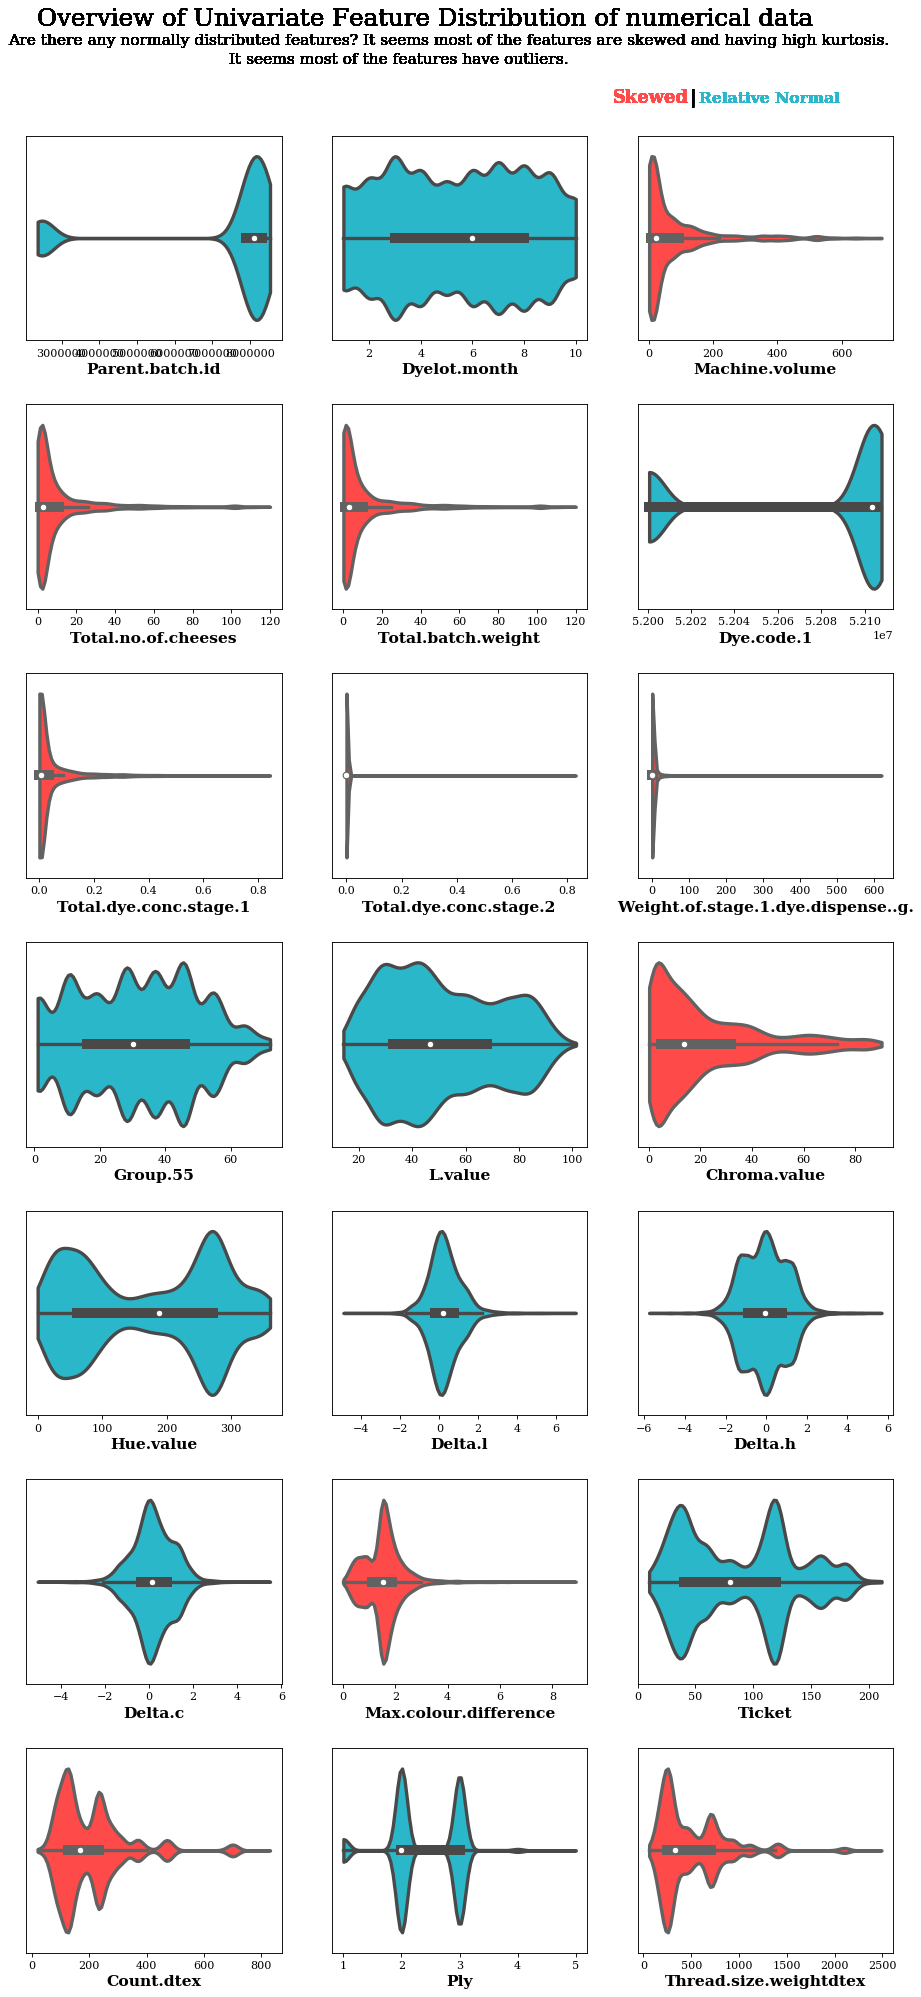

In [26]:
fig,ax = plt.subplots(nrows = 7, ncols = 3, figsize = (12,24),dpi=80)
#fig.patch.set_facecolor(colors[-1])
axes = ax.ravel()

df = Outlier_removed[['parent.batch.id','dyelot.month','machine.volume', 'total.no.of.cheeses', 'total.batch.weight', 
         'dye.code.1','total.dye.conc.stage.1','total.dye.conc.stage.2',
          'weight.of.stage.1.dye.dispense..g.', 'group.55', 'L.value','chroma.value','hue.value', 'delta.l',
          'delta.h', 'delta.c', 'max.colour.difference', 'Ticket','count.dtex', 'ply', 'thread.size.weightdtex' ]]

for col,ax in zip(df.columns,axes):
    
    # skewness and kurtosis
    if skew(df[col])>1:
        color = colors[0]
    else:
        color = colors[1]
        
        
    #Plots
    sns.violinplot(df[col], ax =ax, 
                   color = color, cut =0,
                   inner = 'box',
                   alpha = 1,linewidth = 3, edgecolor = 'solidblack', saturation =1 )
    
    
    ## plot setting
    xlabel = ' '.join([value.capitalize() for value in str(col).split('_') ])
    #ax.set_facecolor(colors[-1])
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xlabel(xlabel,fontfamily='serif',fontsize=14,fontweight='bold', alpha = 1)
    
    plt.tight_layout(pad= 3,h_pad = 2.5, w_pad = 2.5)
    
    
    # titles and text
    fig.text(0.05,1.04,'Overview of Univariate Feature Distribution of numerical data', fontfamily='serif',fontsize=22,fontweight='normal', alpha = 1)
    fig.text(0.02,1.03,'''Are there any normally distributed features? It seems most of the features are skewed and having high kurtosis.''',fontfamily='serif',fontsize=14,fontweight='normal', alpha = 1)
    fig.text(0.25,1.02,'''It seems most of the features have outliers.''',fontfamily='serif',fontsize=14,fontweight='normal', alpha = 1)
    
    fig.text(0.65,1, "Skewed",fontfamily='serif',fontsize=16,fontweight='bold', color=colors[0])
    fig.text(0.73,1, '|',fontfamily='serif',fontsize=16,fontweight='bold')
    fig.text(0.74,1, "Relative Normal",fontfamily='serif',fontsize=14,fontweight='bold', color=colors[1])

    

    fig.show()
    fig.savefig('after_outlier removal')


### Still there is kurtosis present in the weight column and outliers are not completely removed So we will use the logrithmic trasformation to remove the skewness. But due to presence of negative values in some of the features this not a good idea. So we will go for standard scalar while doing the modelling and data binning is another good option for weight columns.

<br><br>
<p style = "font-size:20px"><strong>Data binning for the weight columns</strong></p>

In [27]:
#Copy dataframe after removal in df_train2
df_train2 = Outlier_removed.copy()

#Total.batch.weight bin
batch_weight_bins = [0, 0.5, 1.0, 2.0, 6.0, 12.0, 24.0, 36.0, 72.0, 250.0, 500.0]
batch_weight_values = ['<0.5kg', '0.5kg<1kg', '1.0kg<2.0', '2.0kg<6kg', '6kg<12kg', '12kg<24kg', '12kg<24kg','24kg<36kg','36kg <72kg', '>72kg']
df_train2['total.batch.weight'] = np.array(batch_weight_values)[pd.cut(df_train2['total.batch.weight'], batch_weight_bins, labels=False)]

#'total.dye.conc.stage.1', 'stage.1.dye.conc.band',(unit is %)
stage1_dyeconc_bins = [-0.5, 0.5, 1, 2, 3, 4, 7]
stage1_dyeconc_values = ["<0.5%", "0.5%<1.0%", "1.0%<2.0%", "2.0%<3.0%", "3.0%<4.0%", ">4.0%"]
df_train2['total.dye.conc.stage.1'] = np.array(stage1_dyeconc_values)[pd.cut(df_train2['total.dye.conc.stage.1'], stage1_dyeconc_bins, labels=False)]

#'total.dye.conc.stage.2', 'stage.1.dye.conc.band',(unit is %)
stage2_dyeconc_bins = [-0.5, 0.5, 1, 2, 3, 4, 7]
stage2_dyeconc_values = ["<0.5%", "0.5%<1.0%", "1.0%<2.0%", "2.0%<3.0%", "3.0%<4.0%", ">4.0%"]
df_train2['total.dye.conc.stage.2'] = np.array(stage2_dyeconc_values)[pd.cut(df_train2['total.dye.conc.stage.2'], stage2_dyeconc_bins, labels=False)]


#'stage.1.dispense.wt.band''weight.of.stage.1.dye.dispense..g.
stage1_dyedispense_bins = [-0.5, 0.5, 1, 2, 10, 50, 100, 500, 1000, 10000]
stage1_dyedispense_values = ["<0.5", "0.5<1.0", "1.0<2.0", "2.0<10.0", "10.0<50.0", "50<100", "100<500", "500<1000",  "<1000"]
df_train2['weight.of.stage.1.dye.dispense..g.'] = np.array(stage1_dyedispense_values)[pd.cut(df_train2['weight.of.stage.1.dye.dispense..g.'], stage1_dyedispense_bins , labels=False)]

df_train2 = df_train2.drop(columns=['batch.weight.band', 'stage.1.dye.conc.band', 'stage.1.dispense.wt.band' ])



<br><br><br>

<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Baseline Modeling </h2>

### Till now I have explored all the basic things like cleaning data, handling missing values, outlier removal, feature engineering ... . Now coming to modeling for such a imbalanced raw dataset, Idea is something like this..


1. For applying any machine learning algorithm we need all the data numerical. I will use the basic ordinal Label  encoding technique for start. I will test the baseline model with label encoding in the  beginning and If we find need to use any other encoding technique will explore that idea also.

2. Before applying model will apply the standard scalar to all the data for normalization.

2. Now question is which model i should use...? In order to decide this, I am trying baseline modeling with 3 different types of algorithms for start and check how they will deal with such imbalance data set.
- Logistic regression: basic classification algorithm.
- Random forest : Bagging ensemble technique (advance algorithm)
- Adaboost : Boosting ensemble technique (advance algorithm)

3. stratified Crossvalidation: As the data is imbalanced crossvalidation will help in splitting the data with balance and will test with the all the possible options of the train and test data splits. It will also helps in deciding with which model we should proceed for further investigations.

4. Grid search : Hyperparameter tunning using grid search in order to check the best possible parameters for the model.

5. Then apply static weight blending in the ensemble model.

### Another question which evaluation metrics I should use?

Here the our data is imbalanced. Our model is biased towards predicting passed (1) batches than the failed (0) batches. We want to predict batches correclty which are failed (0) in during dyeing process. Our concentration should be on decreasing the False positive values.

The Model evaluation of my work on this dataset  will be done by ROC_AUC score, therefore my focus will be on improving the ROC_AUC score.

F1-score is also used when we have imbalanced dataset  and the False Negatives and False Positives are crucial. We will also use it as an evaluation metric here for the model assesment.<br><br><br>

In [28]:
#droping unecessary columns and copying data frame df_train2 in df_train2_copy dataframe

df_train2_copy = df_train2.copy()
df_train2_copy = df_train2_copy.drop(columns=['parent.batch.id', 'machine.name', 'machine.manufacturer', 
                                            'machine.model'])

## Label encoding and Normalizing the data using standardscalar
<br>

### Train-Test-Split

I do not have test data with the target, So splitting the training data using train test split. I will start wilth simple 30 % random test data splitting from the training dataset. <br><br>

In [29]:
X = df_train2_copy.drop(columns=['passed'])
y = df_train2_copy['passed']

In [30]:
#Splitting train test split data
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform) #label encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#train test split

<br><br>
## Feature selection using feature Importance
<br>

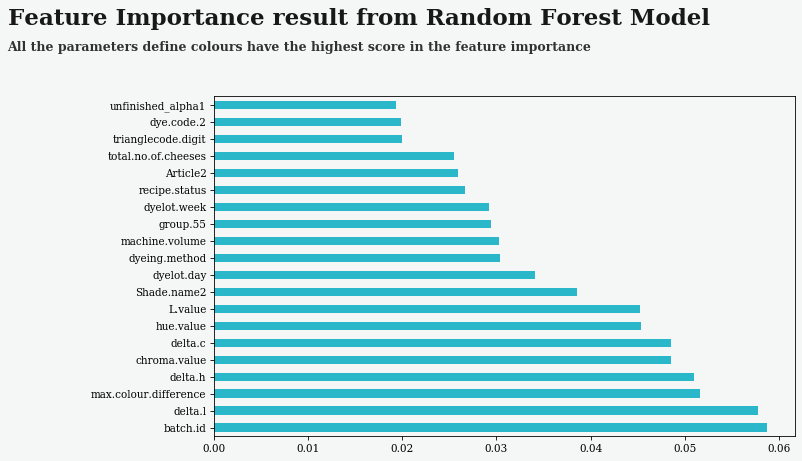

In [31]:
#feature selection
model = RandomForestClassifier()
model.fit(X_train, y_train)
importance_score = model.feature_importances_
ranked_features = pd.Series(model.feature_importances_, index=X_train.columns)
fig = plt.figure(figsize=(10,6),dpi = 75)
fig.patch.set_facecolor('#f5f6f6')

gs = fig.add_gridspec(10,10)
ax = fig.add_subplot(gs[:,:])
ax.set_facecolor('#f5f6f6')

ranked_features.nlargest(20).plot(kind='barh', color='#2ab7ca', ax=ax)


fig.text(-0.150,1.04,'Feature Importance result from Random Forest Model' ,fontfamily='serif',fontsize=22,fontweight='bold', alpha = 0.9)
fig.text(-0.150,0.98,'''All the parameters define colours have the highest score in the feature importance''',fontfamily='serif',fontsize=12,fontweight='bold', alpha = 0.8)
fig.show()
fig.savefig('feature_importance')

<br>

### Out of Feature importance Results
<br>

In [32]:
#importance_score
#column = X.columns
#Stroing feature importance results in a dataframe and using for training dataset only those features
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')
print("Shape of the training data without feature selection : ", X_train.shape)
print("Shape of the training data with feature selection : ", X_test.shape)

column = X_train.columns
selected_features = pd.DataFrame(np.column_stack([importance_score, column]), 
                               columns=['importance_score', 'Column'])
selected_features = selected_features.sort_values(by='importance_score', ascending=False).reset_index().drop(columns=['index'])
selected_features = selected_features['Column'][:25].values
X_train = X_train[selected_features]
X_test  = X_test[selected_features]


print("Shape of the training data with feature selection : ", X_train.shape)
print("Shape of the training data with feature selection : ", X_test.shape)
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')



************************************************************

Shape of the training data without feature selection :  (8411, 46)
Shape of the training data with feature selection :  (3606, 46)
Shape of the training data with feature selection :  (8411, 25)
Shape of the training data with feature selection :  (3606, 25)

************************************************************



<br><br>
### Scaling Using standard scalar

In [33]:

print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.fit(X_test)
scaler.transform(X_test)
print(color_class.BOLD_COLOR+ 'Scaling of the training dataset finished'+ color_class.END +'\n')
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')


************************************************************

Scaling of the training dataset finished


************************************************************



<br><br>


<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Baseline Modelling </h2>
<br>

In [34]:

print(color_class.BOLD + 'Baseline modeling...'+ color_class.END)

classifiers = []
classifiers.append(LogisticRegression(random_state = 100))
classifiers.append(RandomForestClassifier(random_state=100))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=100)))

Algorithms = ["Logistic", "RandomForest", "AdaBoost"]


print(color_class.BOLD_COLOR+ 'Implementation of classifiers'+ color_class.END +'\n')


## empty lists to stores values and states

class_accuracy = []
class_f1 = []
class_auc = []
class_preds = []
class_class_states= []
class_valid_truths = []
class_valid_features = []
class_cm = []


accuracy_list = []
confusionm_list = []
f1score_list = []
auccurve_list = []


for classifier,algo in zip(classifiers,Algorithms):
    class_accuracy = []
    class_f1 = []
    class_auc = []
    class_preds = []
    class_class_states= []
    class_valid_truths = []
    class_valid_features = []
    class_cm = []
    
    
    print(color_class.BOLD + '*'*17+  color_class.END + color_class.BOLD_COLOR + str(algo) + color_class.END + color_class.BOLD +  '*'*17 + color_class.END)
    
    # model 
    model = classifier
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    
    
    ## scores
    #### fold results, feaures,preds, states
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test,preds)
    roc_auc = roc_auc_score(y_test,preds)
    cm = confusion_matrix(y_test,preds)
    
    class_accuracy.append(accuracy)
    class_f1.append(f1)
    class_auc.append(roc_auc)
    class_preds.append(preds)
    class_class_states.append(model)
    class_valid_truths.append(np.array(y_test).astype(int))
    class_valid_features.append(X_test)
    class_cm.append(cm)

    confusionm_list.append(cm)
    accuracy_list.append(accuracy)
    f1score_list.append(f1)
    auccurve_list.append(roc_auc)
    
    ## printing results 
    print(color_class.BOLD)
    print("Accuracy: {}, F1:{}, Roc_Auc: {} ".format(round(accuracy,2),round(f1,2),round(roc_auc,2)))
    print(color_class.END)
        
    print('\n'+  color_class.BOLD+'*'*30 + color_class.END +'\n')

Baseline modeling...
Implementation of classifiers

*****************Logistic*****************

Accuracy: 0.83, F1:0.9, Roc_Auc: 0.5 


******************************

*****************RandomForest*****************

Accuracy: 0.84, F1:0.91, Roc_Auc: 0.57 


******************************

*****************AdaBoost*****************

Accuracy: 0.76, F1:0.85, Roc_Auc: 0.58 


******************************



<br><br>
### Out of baseline model results
<br>

In [35]:
print(color_class.BOLD_COLOR+ 'Results appending from baseline modeling...'+'\n'+ color_class.END)

Baselinemodel_results_df = pd.DataFrame({'Algorithms':['LogisticRegression','RandomForestClassifier','AdaBoostClassifier'],
                                 'Accuracy':accuracy_list,
                                 'f1_score':f1score_list,
                                  'roc_auc_score':auccurve_list,
                       'confusion_matrix':confusionm_list})

print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')  
print(color_class.BOLD + '\n')
print(Baselinemodel_results_df.head())
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')
Baselinemodel_results_df

Results appending from baseline modeling...


************************************************************



               Algorithms  Accuracy  f1_score  roc_auc_score  \
0      LogisticRegression  0.825014  0.903826       0.504855   
1  RandomForestClassifier  0.840821  0.910814       0.572309   
2      AdaBoostClassifier  0.758181  0.853544       0.580915   

            confusion_matrix  
0    [[10, 612], [19, 2965]]  
1   [[101, 521], [53, 2931]]  
2  [[193, 429], [443, 2541]]  

************************************************************



,Algorithms,Accuracy,f1_score,roc_auc_score,confusion_matrix
0,LogisticRegression,0.825014,0.903826,0.504855,"[[10, 612], [19, 2965]]"
1,RandomForestClassifier,0.840821,0.910814,0.572309,"[[101, 521], [53, 2931]]"
2,AdaBoostClassifier,0.758181,0.853544,0.580915,"[[193, 429], [443, 2541]]"


### Confusion matrix plot out of baseline model results
<br>

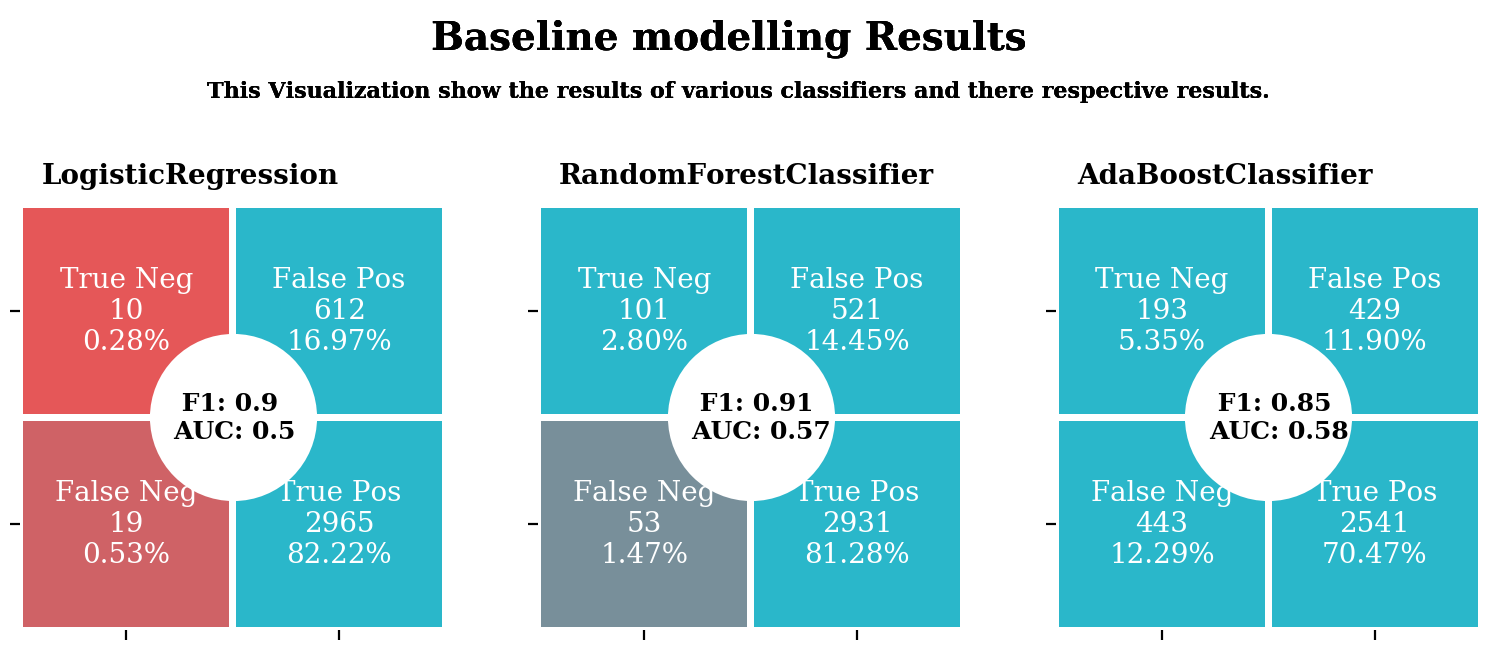

In [36]:
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("",[colors[0],colors[1]])




fig,ax = plt.subplots(1,3, figsize=(8,8))

for algo,f1,auc,cm,axes in zip(Baselinemodel_results_df['Algorithms'],
                                Baselinemodel_results_df['f1_score'],
                                Baselinemodel_results_df['roc_auc_score'],
                               Baselinemodel_results_df['confusion_matrix'],
                                ax.ravel()):

    
    cf_mat = cm
    
    #### annotations
    labels = ['True Neg','False Pos','False Neg','True Pos']
    counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
    #### final annotations
    label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
    
    ##heatmap
    sns.heatmap(data = cf_mat, vmin = 0, vmax =84, cmap = my_cmap,linewidth=2,linecolor = 'white',square = True,
    ax = axes, annot = label, fmt ='', cbar = False, alpha =1)
    
    
    axes.text(0.1,-0.1,'{}'.format(algo),fontfamily='serif',fontsize=10,fontweight='bold')
    
    axes.scatter( 1 , 1 , s = 3500, c = 'white')
    axes.text(0.72,1.1, ' F1: {}\nAUC: {}'.format(round(f1,2), round(auc,2)),fontfamily='serif',fontsize=9,fontweight='bold')
    
    ## ticks and labels
    axes.set_xticklabels('')
    axes.set_yticklabels('')
    
    ## titles and text
    fig.text(0.30,0.73,'Baseline modelling Results', fontfamily='serif',fontsize=14,fontweight='bold', alpha = 1)
    fig.text(0.16,0.7,'''This Visualization show the results of various classifiers and there respective results.''',
             fontfamily='serif',fontsize=8,fontweight='bold', alpha = 0.98)
    
    fig.tight_layout(pad = 2.5, w_pad = 2.5,h_pad = 2.5)
    fig.show()
    fig.savefig('Baseline_modelling_confusion_matrix')

<br><br>

### Observations on  baseline modeling

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.Here for this dataset Adaboost and random forest seems to be working well even without corssvalidation or hyperparamters tunning. So we will try now cross validation and hyperparameter tunning in order to check is there any improvement in AUC score for logistic regression if not then we will proceed with random forest and adboost.Ada boost has the lowest false positive value here.

<br><br>
# Modeling with Crossvalidation
<br><br>

In [37]:
#Scaling
scaler.fit(X)
scaler.transform(X)
X = X[selected_features]
#[selected_features]

print(color_class.BOLD + 'Baseline modeling...'+ color_class.END)

classifiers = []
classifiers.append(LogisticRegression(random_state = 100))
classifiers.append(RandomForestClassifier(random_state=100))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=100)))



stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state  = 20)
Algorithms = ["Logistic", "RandomForest", "AdaBoost"]


print(color_class.BOLD_COLOR+ 'Implementation of classifiers'+ color_class.END +'\n')

## empty lists to stores values and states

class_accuracy = []
class_f1 = []
class_auc = []
class_preds = []
class_class_states= []
class_valid_truths = []
class_valid_features = []
class_cm = []

for classifier,algo in zip(classifiers,Algorithms):
    fold_accuracy = []
    fold_f1 = []
    fold_roc_auc = []
    fold_preds = []
    fold_class_states = []
    fold_valid_truths = []
    fold_valid_features = []
    fold_cm = []
   
    n = 0

    print(color_class.BOLD + '*'*17+  color_class.END + color_class.BOLD_COLOR + str(algo) + color_class.END + color_class.BOLD +  '*'*17 + color_class.END)
    
    #stratified cross validation
    for train_idx,test_idx in stratified.split(X, y):
        xtrain, xtest = X.iloc[train_idx],X.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx],y.iloc[test_idx]
        
        
        # model 
        model = classifier
        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)
        
        
        ## scores
        #### fold results, feaures,preds, states
        accuracy = accuracy_score(ytest, preds)
        f1 = f1_score(ytest,preds)
        roc_auc = roc_auc_score(ytest,preds)
        cm = confusion_matrix(ytest,preds)
        
        
        fold_accuracy.append(accuracy)
        fold_f1.append(f1)
        fold_roc_auc.append(roc_auc)
        fold_preds.append(preds)
        fold_class_states.append(model)
        fold_valid_truths.append(np.array(ytest).astype(int))
        fold_valid_features.append(xtest)
        fold_cm.append(cm)
        
        ## printing results 
        print(color_class.BOLD)
        print("fold{}: Accuracy: {}, F1:{}, Roc_Auc: {} ".format(n, round(accuracy,2),round(f1,2),round(roc_auc,2)))
        print(color_class.END)
        
        n+=1
        
    #### class results, feaures,preds, states
    class_accuracy.append(fold_accuracy)
    class_f1.append(fold_f1)
    class_auc.append(fold_roc_auc)
    class_preds.append(fold_preds)    
    class_valid_truths.append(fold_valid_truths)
    class_valid_features.append(fold_valid_features)
    class_cm.append(fold_cm)
    class_class_states.append(fold_class_states)
    
    ## breif result dynamic prints

    print( color_class.BOLD+ '\n'+'*'*10 +'Means'+ '*'*10+'\n' + color_class.END)
    print(color_class.BOLD_COLOR)
    print('Accuracy Mean: {}'.format(round(np.mean(fold_accuracy),2)))
    print('F1 Mean: {}'.format(round(np.mean(fold_f1),2)))
    print('ROC_AUC Mean: {}'.format(round(np.mean(fold_roc_auc),2)))
    print(color_class.END)
    print('\n'+  color_class.BOLD+'*'*30 + color_class.END +'\n')
    
    


Baseline modeling...
Implementation of classifiers

*****************Logistic*****************

fold0: Accuracy: 0.83, F1:0.91, Roc_Auc: 0.51 


fold1: Accuracy: 0.83, F1:0.91, Roc_Auc: 0.51 


fold2: Accuracy: 0.83, F1:0.91, Roc_Auc: 0.51 


fold3: Accuracy: 0.83, F1:0.91, Roc_Auc: 0.51 


fold4: Accuracy: 0.83, F1:0.91, Roc_Auc: 0.52 


**********Means**********


Accuracy Mean: 0.83
F1 Mean: 0.91
ROC_AUC Mean: 0.51


******************************

*****************RandomForest*****************

fold0: Accuracy: 0.84, F1:0.91, Roc_Auc: 0.57 


fold1: Accuracy: 0.85, F1:0.91, Roc_Auc: 0.59 


fold2: Accuracy: 0.84, F1:0.91, Roc_Auc: 0.58 


fold3: Accuracy: 0.84, F1:0.91, Roc_Auc: 0.58 


fold4: Accuracy: 0.84, F1:0.91, Roc_Auc: 0.58 


**********Means**********


Accuracy Mean: 0.84
F1 Mean: 0.91
ROC_AUC Mean: 0.58


******************************

*****************AdaBoost*****************

fold0: Accuracy: 0.75, F1:0.85, Roc_Auc: 0.58 


fold1: Accuracy: 0.76, F1:0.85, Roc_Auc: 0.

### Out of the Stratified KFold results

In [38]:
print(color_class.BOLD_COLOR+ 'Storing results into dataframe....\n'+ color_class.END)

class_accuracy
class_f1
class_auc


results_df = pd.DataFrame({'Algorithms': Algorithms, 
                           'Mean Accuracy':np.row_stack(class_accuracy).mean(axis = 1), 
                           'Mean F1':np.row_stack(class_f1).mean(axis = 1),
                            'Mean Roc_Auc':np.row_stack(class_auc).mean(axis = 1),
                           
                          }).sort_values(by
                        ='Mean Roc_Auc',ascending =True).reset_index(drop = True)



results_df

Storing results into dataframe....



,Algorithms,Mean Accuracy,Mean F1,Mean Roc_Auc
0,Logistic,0.830241,0.906781,0.510852
1,RandomForest,0.844138,0.912669,0.577997
2,AdaBoost,0.758093,0.852749,0.591359


### Means of out of the fold predictions........

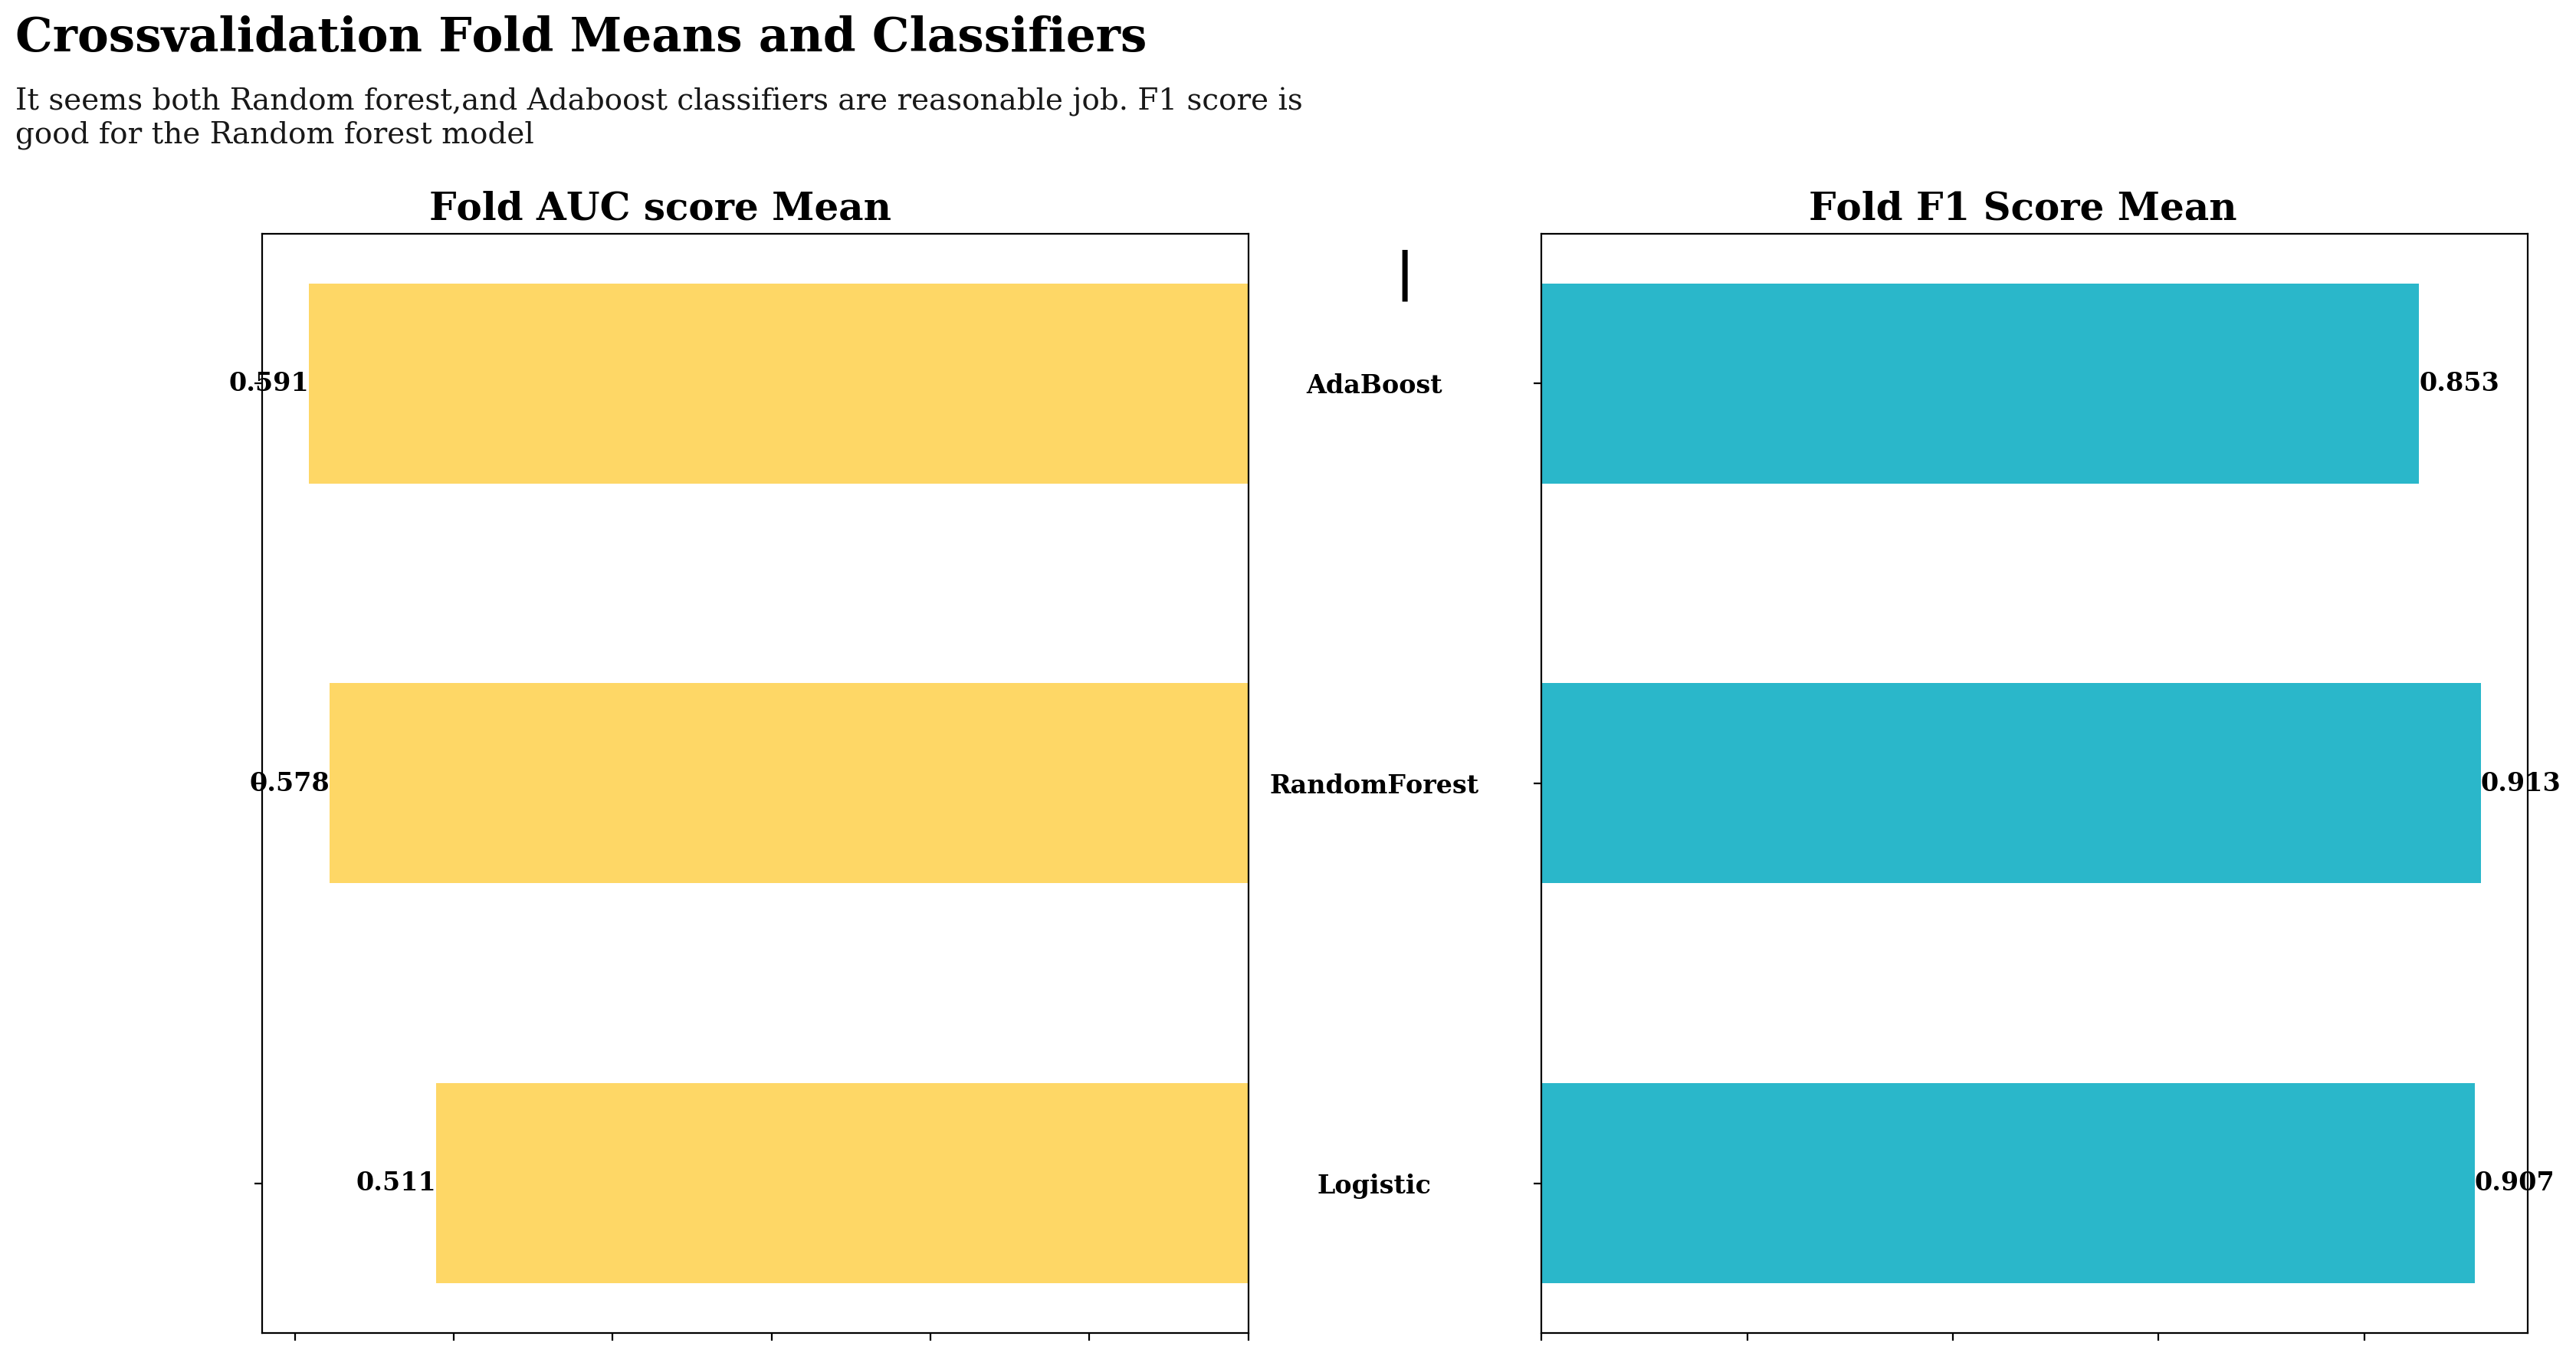

In [39]:
fig, ax = plt.subplots(1,2,figsize = (18,10))

axes = ax.ravel()

axes[0].invert_xaxis()
color_list = results_df['Mean Roc_Auc'].apply(lambda x: colors[2])
axes[0].barh(y = results_df['Algorithms'], width = round(results_df['Mean Roc_Auc'],3), height = 0.5, color = color_list)
for pa in ax[0].patches:
    ax[0].text(pa.get_width(),pa.get_y()+pa.get_height()/2, pa.get_width(), ha = 'right', va = 'center',fontfamily='serif',fontsize=12,fontweight='bold')


color_list1 = results_df['Mean F1'].apply(lambda x: colors[1] )
axes[1].barh(y = results_df['Algorithms'], width = round(results_df['Mean F1'],3), height = 0.5, color = color_list1)
for pa in ax[1].patches:
    ax[1].text(pa.get_width(),pa.get_y()+pa.get_height()/2, pa.get_width(), ha = 'left',va = 'center', 
               fontfamily='serif',fontsize=12,fontweight='bold')


axes[0].set_yticklabels('')
axes[1].set_yticklabels(results_df['Algorithms'], fontfamily='serif',fontsize=12,
                                                   fontweight='bold',rotation = 0,ha= 'center')
axes[1].tick_params(axis = 'y',pad = 75)
axes[0].set_xticklabels('')
axes[1].set_xticklabels('')

## titles and text
fig.text(0,0.98,'Crossvalidation Fold Means and Classifiers', fontfamily='serif',fontsize=22,fontweight='bold', alpha = 1)
fig.text(0,0.92,'''It seems both Random forest,and Adaboost classifiers are reasonable job. F1 score is 
good for the Random forest model''',fontfamily='serif',fontsize=14,fontweight='normal', alpha = 0.9)

fig.text(0.15,0.87, "Fold AUC score Mean",fontfamily='serif',fontsize=18,fontweight='bold')
fig.text(0.5,0.825, '|',fontfamily='serif',fontsize=24,fontweight='bold')
fig.text(0.65,0.87, "Fold F1 Score Mean",fontfamily='serif',fontsize=18,fontweight='bold')


fig.tight_layout(pad = 10,w_pad = 1, h_pad = 10)
fig.show()

fig.savefig('Baseline_modelling_aucscore')

<br><br>
# Hyperparameters Tunning and Crossvalidation
<br><br>

In [40]:
print(color_class.BOLD + 'Hyperparameters tunning grid...'+ color_class.END)
classifiers_params = {
    
    LogisticRegression(): {'C':[0.001,0.01,0.05,0.1,0.5,1,10,100,200,1000] , 
                  'penalty': ['l1','l2']} ,
                                         
    RandomForestClassifier() :     {
                   'class_weight': [{1:6,0:4}],
                   'max_depth': [2,4,6,8,10],
                   'max_leaf_nodes': [5,10,15],
                   'n_estimators': np.arange(100,2000,500)} ,
    AdaBoostClassifier() :    {
                   'base_estimator': [DecisionTreeClassifier()],
                   'learning_rate': [0.01,0.05,0.1],
                   'n_estimators': np.arange(100,1000,500)} ,
}


Hyperparameters tunning grid...


<br><br>

In [41]:
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)


print(color_class.BOLD_COLOR+ 'Scaling of the dataset finished'+ color_class.END +'\n')
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')

print(color_class.BOLD_COLOR+ 'Gridsearch CV implementation with predefined grid params'+ color_class.END +'\n')
xtrain,xtest,ytrain,ytest = train_test_split(X[selected_features], y,random_state = 100, shuffle = True,stratify= y)


best_est = []
best_pms = []

for clf,params in classifiers_params.items():
    print(color_class.BOLD + '*'*60 + color_class.END +'\n')
    
    gs = GridSearchCV(estimator= clf, param_grid = params,cv = stratified, verbose= 2,
                      scoring = 'roc_auc',n_jobs = -1)
        #gs = clf
    gs.fit(xtrain,ytrain)
    best_estimator = gs.best_estimator_
    best_params = gs.best_params_
    best_est.append(best_estimator)
    best_pms.append(best_params)
    preds = best_estimator.predict(xtest)
    
    
    print(color_class.BOLD)
    print(best_estimator)
    
    print('Accuracy: {}'.format(accuracy_score(ytest,preds)))
    print('F1 score: {}'.format(f1_score(ytest,preds)))
    print('Roc_Auc: {}'.format(round(roc_auc_score(ytest,preds),8)))
    print(color_class.BOLD + '*'*60 + color_class.END +'\n')



************************************************************

Scaling of the dataset finished


************************************************************

Gridsearch CV implementation with predefined grid params

************************************************************

Fitting 5 folds for each of 20 candidates, totalling 100 fits

LogisticRegression(C=0.05)
Accuracy: 0.83261231281198
F1 score: 0.9082284254698049
Roc_Auc: 0.51171775
************************************************************

************************************************************

Fitting 5 folds for each of 60 candidates, totalling 300 fits

RandomForestClassifier(class_weight={0: 4, 1: 6}, max_depth=10,
                       max_leaf_nodes=15, n_estimators=1100)
Accuracy: 0.8299500831946756
F1 score: 0.9070740134569922
Roc_Auc: 0.5
************************************************************

************************************************************

Fitting 5 folds for each of 6 candidates, totall

In [42]:
print(color_class.BOLD_COLOR+ 'Results appending from gridsearch...'+'\n'+ color_class.END)

acc_list = []
cm_list = []
f1_list = []
auc_list = []

for clf in best_est:
    preds = clf.predict(xtest)
    cm = confusion_matrix(ytest,preds)
    acc = accuracy_score(ytest,preds)
    f1 = f1_score(ytest,preds)
    auc = roc_auc_score(ytest,preds)
    cm_list.append(cm)
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)


hyper_results_df = pd.DataFrame({'Algorithms':['LogisticRegression','RandomForestClassifier','AdaBoostClassifier'],
                                 'Accuracy':acc_list,
                                 'f1_score':f1_list,
                                  'roc_auc_score':auc_list,
                                  'confusion_matrix':cm_list})
print(color_class.BOLD + '\n')
print(hyper_results_df.head())


Results appending from gridsearch...



               Algorithms  Accuracy  f1_score  roc_auc_score  \
0      LogisticRegression  0.832612  0.908228       0.511718   
1  RandomForestClassifier  0.829950  0.907074       0.500000   
2      AdaBoostClassifier  0.755408  0.850822       0.590463   

            confusion_matrix  
0     [[13, 498], [5, 2489]]  
1      [[0, 511], [0, 2494]]  
2  [[174, 337], [398, 2096]]  


<br><br>
### Confusion Matrix visualizations of best estimated parameters from Grid search results......
<br>

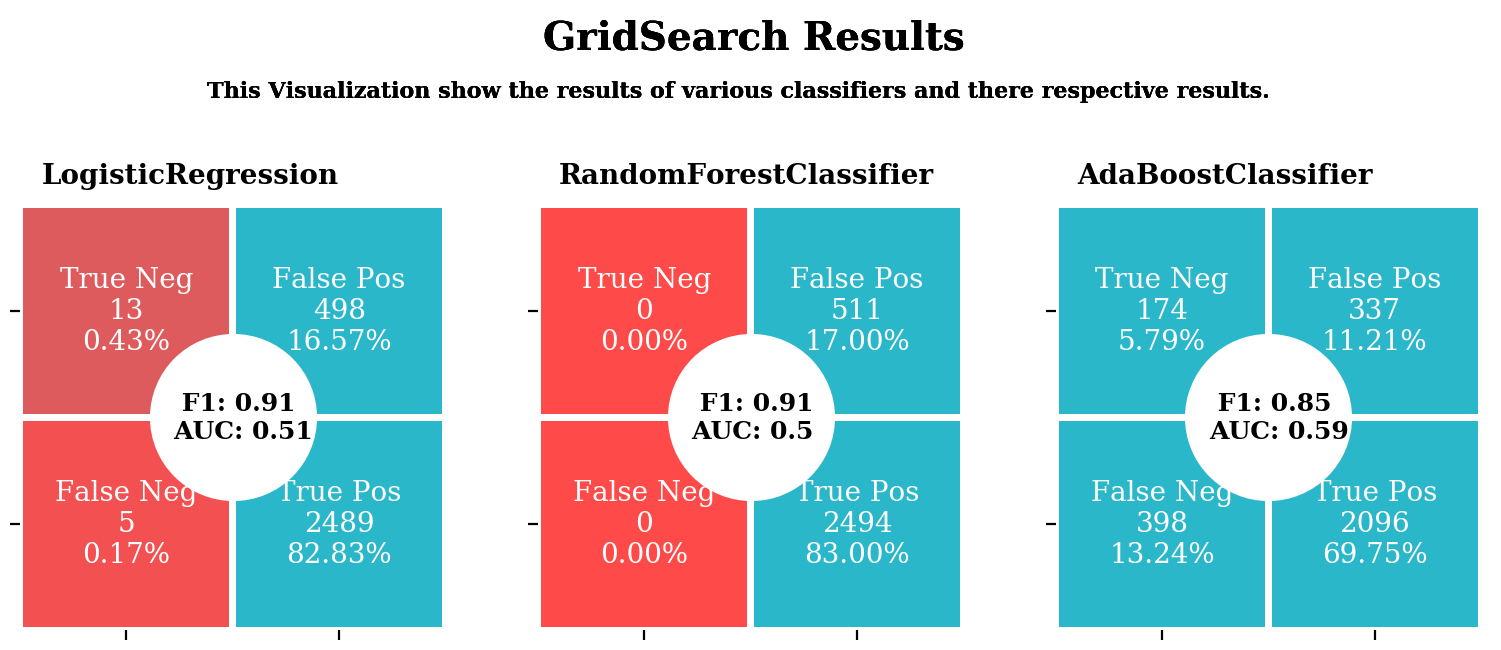

In [43]:
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("",[colors[0],colors[1]])




fig,ax = plt.subplots(1,3, figsize=(8,8))

for algo,f1,auc,cm,axes in zip(hyper_results_df['Algorithms'],
                                hyper_results_df['f1_score'],
                                hyper_results_df['roc_auc_score'],
                                hyper_results_df['confusion_matrix'],
                                ax.ravel()):

    
    cf_mat = cm
    
    #### annotations
    labels = ['True Neg','False Pos','False Neg','True Pos']
    counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
    #### final annotations
    label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
    
    ##heatmap
    sns.heatmap(data = cf_mat, vmin = 0, vmax =84, cmap = my_cmap,linewidth=2,linecolor = 'white',square = True,
    ax = axes, annot = label, fmt ='', cbar = False, alpha =1)
    
    
    axes.text(0.1,-0.1,'{}'.format(algo),fontfamily='serif',fontsize=10,fontweight='bold')
    
    axes.scatter( 1 , 1 , s = 3500, c = 'white')
    axes.text(0.72,1.1, ' F1: {}\nAUC: {}'.format(round(f1,2), round(auc,2)),fontfamily='serif',fontsize=9,fontweight='bold')
    
    ## ticks and labels
    axes.set_xticklabels('')
    axes.set_yticklabels('')
    
    ## titles and text
    fig.text(0.37,0.73,'GridSearch Results', fontfamily='serif',fontsize=14,fontweight='bold', alpha = 1)
    fig.text(0.16,0.7,'''This Visualization show the results of various classifiers and there respective results.''',
             fontfamily='serif',fontsize=8,fontweight='bold', alpha = 0.98)
    
    fig.tight_layout(pad = 2.5, w_pad = 2.5,h_pad = 2.5)
    fig.show()
    fig.savefig('Hyperparameter_tunning_confusion_matrix')

### Observations:

False positive Values are significantly reduced in case of Adaboostclassifier, almost 10% decrease in False positive values fromthe baseline results. therefore slight increase in the AUC_score observed. 

It is clear that Adaboost model performance reasonably good compared to the rest of the model.So next step will be now to find optimal threshold for the binary classsifcation problem using probability of occurence for both the classes (0, 1).
<br><br>

## How to select optimal threshold for binary classification problem?
<br><br>

So Here I have estimated the probability of the binary classification for all the 3 models. I took mean of probabilities for all the models and saved in final predictions. Then roc curve is estimated which gives 3 values fpr, tpr and thresholds. We get all the threshold values for estimated mean probabilities. So if the prabablity is greater than threshold than class 0 else 1. With these threshold values we did the predictions for test data and then estimated the accuracy score.

but now question is which threshold value we can select?<br>

Threshold value with the highest score will be considered for future classification.

<br><br>

In [44]:
pred = []
for clf in best_est:
    pred.append(pd.Series(clf.predict_proba(xtest)[:, 0]))
#Probability prediction column given 2 columns 0 and 1 so i have selected probability of faliure
final_prediction =pd.concat(pred, axis=1).mean(axis=1)
print("\nProbabilities for class 0 estimated out of all the model's best parameters:\n", pd.concat(pred, axis=1))
print(final_prediction)
print('\nEnsemble test roc-auc: {}\n'.format(roc_auc_score(ytest, final_prediction)))

fpr, tpr, thresholds = roc_curve(ytest, final_prediction)
print('\nThreshold Values for binary classification estimated from probability:\n', thresholds)
#Which threshold value I should select out of this values
#Out of the predictions of probability which is greater than threshold is 0 else 1


accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction > thres, 0, 1)
    accuracy_ls.append(accuracy_score(ytest, y_pred, normalize=True))
print("\nHere the predictions out of probability results out of all models:\n", y_pred)
print("\nAdding accuracy score in accuracy_ls column:\n", accuracy_ls)


#appending accuracy score of ypred and ytest in accuracy column
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis=1)

print("\nAccuracy score for all the threshold values:\n", accuracy_ls)

accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls = accuracy_ls.reset_index()
print('\nSelect highest acuuracy score threshold value for predictions for the test data:\n', accuracy_ls)
#We go for highest accuracy value of the threshold


Probabilities for class 0 estimated out of all the model's best parameters:
              0         1             2
0     0.094766  0.066976  2.220446e-16
1     0.182457  0.136534  2.220446e-16
2     0.069626  0.066143  2.220446e-16
3     0.092433  0.068549  2.220446e-16
4     0.072313  0.068715  2.220446e-16
...        ...       ...           ...
3000  0.152022  0.151091  2.220446e-16
3001  0.086936  0.078690  2.220446e-16
3002  0.145577  0.084958  2.220446e-16
3003  0.207734  0.172114  2.220446e-16
3004  0.174688  0.126607  1.000000e+00

[3005 rows x 3 columns]
0       0.053914
1       0.106330
2       0.045256
3       0.053661
4       0.047009
          ...   
3000    0.101038
3001    0.055209
3002    0.076845
3003    0.126616
3004    0.433765
Length: 3005, dtype: float64

Ensemble test roc-auc: 0.27505308238794635


Threshold Values for binary classification estimated from probability:
 [1.67269614 0.67269614 0.63691775 0.63423985 0.59807363 0.57803113
 0.56968666 0.56310151 0.558


Here the predictions out of probability results out of all models:
 [0 0 0 ... 0 0 0]

Adding accuracy score in accuracy_ls column:
 [0.8299500831946756, 0.8299500831946756, 0.8309484193011647, 0.8312811980033278, 0.8322795341098169, 0.831946755407654, 0.83261231281198, 0.83261231281198, 0.83261231281198, 0.8329450915141431, 0.8329450915141431, 0.8322795341098169, 0.8322795341098169, 0.83261231281198, 0.8322795341098169, 0.8322795341098169, 0.8332778702163062, 0.8332778702163062, 0.8329450915141431, 0.83261231281198, 0.8329450915141431, 0.8332778702163062, 0.8342762063227953, 0.8342762063227953, 0.8342762063227953, 0.8332778702163062, 0.8329450915141431, 0.8329450915141431, 0.8329450915141431, 0.8332778702163062, 0.8332778702163062, 0.8336106489184693, 0.8336106489184693, 0.8339434276206322, 0.8342762063227953, 0.83261231281198, 0.8322795341098169, 0.831946755407654, 0.8316139767054909, 0.831946755407654, 0.831946755407654, 0.8302828618968386, 0.8299500831946756, 0.8302828618968386, 0

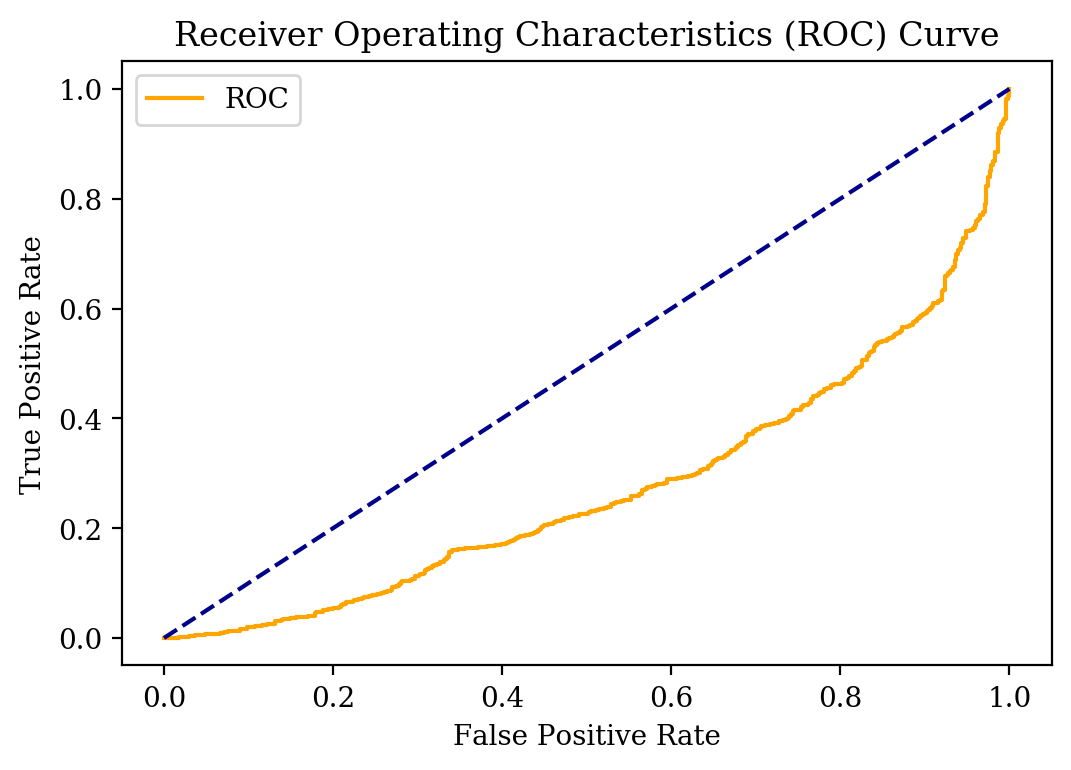

In [45]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0,1], [0,1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics (ROC) Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr, tpr) 

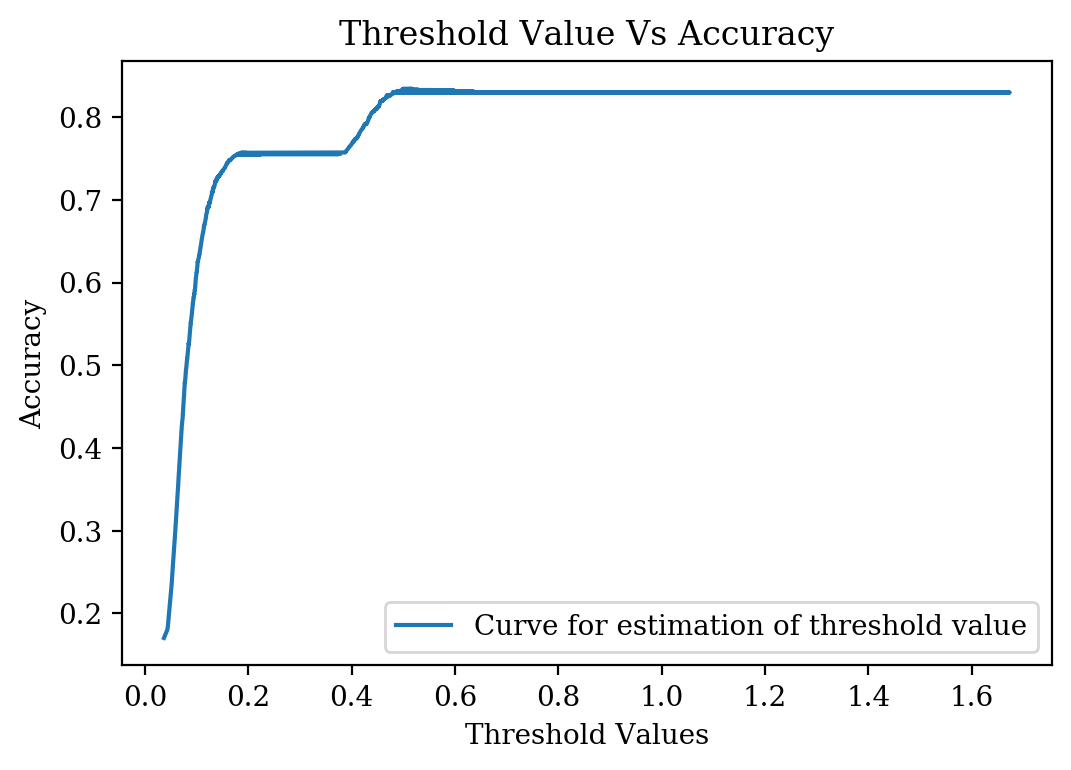

************************************************************

Optimal threshold value for class 0 predictions is : 0.5140856996792361 

************************************************************



In [46]:
def plot_Thresholdvalue_curve(x, y):
    plt.plot(accuracy_ls['thresholds'],accuracy_ls['accuracy'], label='Curve for estimation of threshold value')
    plt.xlabel('Threshold Values')
    plt.ylabel('Accuracy')
    plt.title('Threshold Value Vs Accuracy')
    plt.legend()
    plt.show()

x = accuracy_ls['thresholds']
y = accuracy_ls['accuracy']
plot_Thresholdvalue_curve(x, y)

print(color_class.BOLD + '*'*60 + color_class.END +'\n')
print('Optimal threshold value for class 0 predictions is :', accuracy_ls['thresholds'][0], '\n')
print(color_class.BOLD + '*'*60 + color_class.END +'\n')

<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: gold ; color : 'black'; text-align: left; border-radius: 2px 2px;pad:4px;"> Cleaning test data </h2>


## Finally we will clean test data and will test the model 

In [52]:
#data frame contains test data is df_test 

#shape of the data
df_test 


print('\n'+'*'*15 + 'Shapes of Data' + '*'*15+'\n' )

print('Shape of the Test dataset: {}'.format(df_test.shape))


print('\n'+'*'*50 + '\n')

print('Information of the test data set:')




#Duplicate rows removed

def dup_rows_index(df):
    dup = df[df.duplicated()]
    print('\n\nDuplicated index list:',dup[dup == True ].index.tolist())
    return dup
dup_rows_index(df_test)
print('\n'+'*'*50 + '\n')
df_test = df_test.drop_duplicates(subset=['batch.id'], keep='first')
print('Any duplicate rows present: {}'.format(df_test.duplicated().any()))
print('Any duplicate rows present now removed')
print('\n'+'*'*50 + '\n')


#Missing value treatment
missing_zero_values_table(df_test)
df_test1 = df_test.dropna(subset=['machine.manufacturer', 'L.value', 'material.code'], axis=0)
df_test1 = (df_test1.reset_index()).drop(columns=['index', 'triangle.code.2', 'dye.code.4', 'dye.code.5', 'dye.code.6', 'extra'])
print('\n'+color_class.BOLD_COLOR+ 'Most of the missing values containing rows removed except traingle.code.1 column'+ color_class.END + '\n' )
missing_zero_values_table(df_test1)

#columns with one category removed
df_test2 = df_test1.drop(['recipe.type', 'recipe.type.code', 'dyelot.year','lub.type.name', 'substrate.used.for', 'dyelot.date'], axis='columns')
df_test2 = (df_test2.reset_index()).drop(columns='index')
print('\n'+color_class.BOLD_COLOR+ 'Columns with one category are removed'+ color_class.END + '\n' )


#Decoding columns:
#triangle.code.1 column, 'trianglecode.N' deleted and splitted into 2 columns
trianglecode = df_test2['triangle.code.1'].str.split('([A-Za-z]+)(\d+)', expand=True)
trianglecode = trianglecode.loc[:,[1,2,3]]
trianglecode.rename(columns={1:'trianglecode.alphabet', 2:'trianglecode.digit', 3:'trianglecode.N'}, inplace=True)
trianglecode = (trianglecode[['trianglecode.alphabet', 'trianglecode.digit', 'trianglecode.N']].fillna('0')).replace('', '0')


#countply column
countply = df_test2['count.ply'].str.split('(\d+)', expand=True)
countply = countply.loc[:,[1,2,3]]
countply.rename(columns={1:'count.dtex', 2:'x', 3:'ply'}, inplace=True)
countply = countply.astype({"count.dtex":'float', "ply":'float'})#But the count and ply column is object need to convert object to float
countply['thread.size.weightdtex'] = countply ['count.dtex'] * countply ['ply'] #In order to get the resultant thread size we will have to multiply the yarn count with ply.


#unfinished.standard.type split into three columns alpha 1 has information but rest 2 are substrate code and no new information so removed
unifinished_standard_type = df_test2['unfinished.standard.type'].str.split(pat = '-', expand=True).rename(columns={0:'unfinished_alpha1', 1:'unfinished_alpha2', 2:'unfinished_alpha3'}).fillna('0')
unifinished_standard_type = unifinished_standard_type.drop(columns = ['unfinished_alpha2', 'unfinished_alpha3'])



#Thread.group column is splitted into the thread_group_country
thread_group = df_test2['thread.group'].str.split(pat = '-', expand=True).rename(columns={0:'substrate', 1:'thread_group1', 2:'thread_group_country'})
replace_substrate = {'CFP': '', 'IBP': '', 'IBN':'', 'PPC':'', 'SSP':'', 'TXP 2':'', 'TXP 1':'', 'SSP FINE':'',
       'SSP MEDIUM': '', 'MFP': '', 'CFPB': '', 'HTXP': '', 'PPC UPP': '',
       'IBN 235X3 INVISTA (CHINA)': 'INVISTA (CHINA)', '700X1 HYOSUNG': 'HYOSUNG', 'SSP 130x2 YZ': 'YZ',
       'TXP': '', 'CFN': '', 'CFR': '', 'PTT': '', 'TRP': '', 'CFP MED (ZHONGTAI ': 'ZHONGTAI',
       'PCC 490X2 ZHONGTAI': 'ZHONGTAI', 'PPC 365X2 ZHONGTAI (NM)':'ZHONGTAI (NM)', 'CFP ': '',
       'MFP FINE ': '', 'SSPC': '', 'TXN': '', 'PCC 1100X2': '', 'TXP 110/2': '',
       'PBT 370X2 GLOBAL': 'GLOBAL', 'CFP 138/3': '', '400X4': '', '940X1 HYOSUNG':'HYOSUNG' ,
       'TRP SYL_AR': '', 'SSP VERY COARSE (T393)': '', '6FN FINE': '', 'PPC 365X2 ': '',
       'PCC FINE (TEIJIN +DCH)':'TEIJIN +DCH' , '484X2 ZHONGTAI': 'ZHONGTAI', 'SSP 394X3 R52': '',
       'IBP COURSE (WESTER)': 'WESTER', 'CFN FINE': '', 'PCC COARSE (HYOSUNG + DCH)': 'HYOSUNG+DCH',
       'CFP COARSE (ZHONGTAI INDO)': 'ZHONGTAI INDO', 'CFP 112X3 ZHONGTAI (INDO ': 'ZHONGTAI (INDO)',
       'CFN 110X2 (SHENMA)': 'SHENMA', 'SSPC MED (GCY)': '',
       'PCC MEDIUM (HYOSUNG + DCH)': 'HYOSUNG+DCH', 'PBT': '', 'PPCV COARSE': '',
       'PPC UPP_MISCO T333': '', 'CFN 700X3 HYOSUNG':'HYOSUNG' , 'PBT 167X2 TASDELEN': 'TASDELEN',
       'PCC VCOARSE (HYOSUNG+DCH)': 'HYOSUNG+DCH', 'CFP 660/3':'', 'PCC FINE':'', 'CFN VCOARS': '',
                    'J)TAICANG(YZ': 'TAICANG(YZ)' }
replace_thread_group_country = {'M' : '', 'C' : '', 'F' : '', 'None' : '', 'T393' : '', 'SHENMA (HIGH TWIST)':'SHENMA',
                                'G82 (MICRO)': '', '303K' : '', 'Micro' : '', 'VERY COARSE' :'', 'DCH' : '',
                                'COARSE': '', 'DCH)':'', 'J)TAICANG(YZ': 'TAICANG(YZ)',
                            'TAICANG (YZ': 'TAICANG (YZ)', 'TEIJIN (MICRO)': 'TEIJIN'}
replace_thread_group1 = {'235X3' : '', 'FINE': '', 'None': '', 'COARSE COUNT': '', '484X2': '', 'MEDIUM': '', '312X3' : '', '470X3' : '', '125X2': '', '130X2' : '', 
                         'COARSE': '', '8G/D': '', '7G/D': '','87X2': '', '110X2':'' , 'R52': '', 'MISCO T333': '', 'NEW' : '', 
                         'Fine': '', '205X2 ZHONGTAI (NEW MERGE)': 'ZHONGTAI', 'MED' : '',  'ZNG': 'ZHONGTAI', '235X2': '',
                         'JIPO': '', 'FINE ': '', '83X3': '', ' DCH': '', '74X3': '',  '1670X3': '', '57X3': '', 'GCY': '', 'G2': '', 
                         '74X2': '', 'G3': '', '167X2': '', 'S': '', '455x3': '', ' NEW LOT)': '', 'VCOARSE (UNIFULL)' : '', '470x1': '',
                         '235x2': '', '226x3': '', ' 550X3 ': '', '95x3': '', '138x3': '', '303K': '', '660X3': '', '830x3': '', '133X3': '', 
                         '1400x3': '', "S (PERF']": '', "'S (PERF']": '',' VCOARSE (UNIFULL)': '', 'J)TAICANG(YZ': 'TAICANG(YZ)' }
thread_group = thread_group.replace({'substrate':replace_substrate, "thread_group_country": replace_thread_group_country, "thread_group1": replace_thread_group1 })
thread_group['thread_group_country'] = thread_group['substrate'] + thread_group['thread_group_country'] + thread_group['thread_group1']
thread_group = thread_group.replace({'thread_group_country': {'J)TAICANG(YZ': 'TAICANG (YZ)', 'ZHONGTAI (FE)57X2': 'ZHONGTAI(FE)', 'LOCAL ' : 'LOCAL'}  })
thread_group = thread_group.fillna('0').replace('', '0')
thread_group = thread_group.drop(columns = ['substrate', 'thread_group1'])


#Concating all the decoded columns
df_test2 = pd.concat([df_test2, trianglecode, countply, unifinished_standard_type, thread_group], axis=1).drop(columns=['triangle.code.1', 'trianglecode.N', 'x',
            'count.ply', 'dyeclasses', 'A.value', 'B.value','shade.name', 'material.code', 'unfinished.standard.type','fibre.type', 'thread.group'])
df_test2 = df_test2.reset_index().drop(columns=['index'])
print('\n'+color_class.BOLD_COLOR+ 'Coded is decoded'+ color_class.END + '\n' )


#Outlier removed
Outlier_removed = df_test2[(np.abs(stats.zscore(df_test2[['parent.batch.id','dyelot.month','machine.volume', 'total.no.of.cheeses', 'total.batch.weight', 
         'dye.code.1','total.dye.conc.stage.1','total.dye.conc.stage.2',
          'weight.of.stage.1.dye.dispense..g.', 'group.55', 'L.value','chroma.value','hue.value', 'delta.l',
          'delta.h', 'delta.c', 'max.colour.difference', 'Ticket','count.dtex', 'ply', 'thread.size.weightdtex' ]])) < 3).all(axis=1)]
print('\n'+color_class.BOLD_COLOR+ 'Outlier removed'+ color_class.END + '\n' )
#Copy dataframe after removal in df_train2
df_test2 = Outlier_removed.copy()


#Total.batch.weight bin
batch_weight_bins = [0, 0.5, 1.0, 2.0, 6.0, 12.0, 24.0, 36.0, 72.0, 250.0, 500.0]
batch_weight_values = ['<0.5kg', '0.5kg<1kg', '1.0kg<2.0', '2.0kg<6kg', '6kg<12kg', '12kg<24kg', '12kg<24kg','24kg<36kg','36kg <72kg', '>72kg']
df_test2['total.batch.weight'] = np.array(batch_weight_values)[pd.cut(df_test2['total.batch.weight'], batch_weight_bins, labels=False)]

#'total.dye.conc.stage.1', 'stage.1.dye.conc.band',(unit is %)
stage1_dyeconc_bins = [-0.5, 0.5, 1, 2, 3, 4, 7]
stage1_dyeconc_values = ["<0.5%", "0.5%<1.0%", "1.0%<2.0%", "2.0%<3.0%", "3.0%<4.0%", ">4.0%"]
df_test2['total.dye.conc.stage.1'] = np.array(stage1_dyeconc_values)[pd.cut(df_test2['total.dye.conc.stage.1'], stage1_dyeconc_bins, labels=False)]

#'total.dye.conc.stage.2', 'stage.1.dye.conc.band',(unit is %)
stage2_dyeconc_bins = [-0.5, 0.5, 1, 2, 3, 4, 7]
stage2_dyeconc_values = ["<0.5%", "0.5%<1.0%", "1.0%<2.0%", "2.0%<3.0%", "3.0%<4.0%", ">4.0%"]
df_test2['total.dye.conc.stage.2'] = np.array(stage2_dyeconc_values)[pd.cut(df_test2['total.dye.conc.stage.2'], stage2_dyeconc_bins, labels=False)]


#'stage.1.dispense.wt.band''weight.of.stage.1.dye.dispense..g.
stage1_dyedispense_bins = [-0.5, 0.5, 1, 2, 10, 50, 100, 500, 1000, 10000]
stage1_dyedispense_values = ["<0.5", "0.5<1.0", "1.0<2.0", "2.0<10.0", "10.0<50.0", "50<100", "100<500", "500<1000",  "<1000"]
df_test2['weight.of.stage.1.dye.dispense..g.'] = np.array(stage1_dyedispense_values)[pd.cut(df_test2['weight.of.stage.1.dye.dispense..g.'], stage1_dyedispense_bins , labels=False)]
df_test2 = df_test2.drop(columns=['batch.weight.band', 'stage.1.dye.conc.band', 'stage.1.dispense.wt.band' ])


#droping unecessary columns and copying data frame df_train2 in df_train2_copy dataframe

df_test2_copy = df_test2.copy()
df_test2_copy = df_test2_copy.drop(columns=['parent.batch.id', 'machine.name', 'machine.manufacturer', 
                                            'machine.model'])

#label encoding
X_test = df_test2_copy
X_test = X_test.apply(le.fit_transform)
print('\n'+color_class.BOLD_COLOR+ 'encoding done'+ color_class.END + '\n' )



print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')
#Feature selection
print("Shape of the test before feature selection : ", X_test.shape)
X_test = X_test[selected_features]
print("Shape of the test data after feature selection : ", X_test.shape)
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')

#standardscaler

scaler = StandardScaler()
scaler.fit(X_test)
scaler.transform(X_test)
print("Scaling done")
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')

#Training data
X_train = df_train2_copy.drop(columns=['passed'])
y_train = df_train2_copy['passed']
X_train = X_train.apply(le.fit_transform)
X_train = X_train[selected_features]
scaler.fit(X_train)
scaler.transform(X_train)
print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')

print("Shape of the training data : ", X_train.shape)
print("Shape of the test data : ", X_test.shape)
print("Shape of the target training  data : ", y_train.shape)

print('\n'+  color_class.BOLD+'*'*60 + color_class.END +'\n')



#Applying adboost model for the predictions with best parameters from cross validation and hyperparametr tuning
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1,
                   n_estimators=600)
model.fit(X_train,y_train)


***************Shapes of Data***************

Shape of the Test dataset: (2460, 68)

**************************************************

Information of the test data set:


Duplicated index list: [867, 873, 881, 1781, 1908, 2337]

**************************************************

Any duplicate rows present: False
Any duplicate rows present now removed

**************************************************


**************************************************

Selected dataframe has 68 columns and 2454 Rows.
There are 21 columns that have missing values.

**************************************************


Most of the missing values containing rows removed except traingle.code.1 column


**************************************************

Selected dataframe has 63 columns and 2427 Rows.
There are 1 columns that have missing values.

**************************************************


Columns with one category are removed


Coded is decoded


Outlier removed


encoding done


**********

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1,
                   n_estimators=600)

### I have here given 2 predictions one whcch is direclty coming from adboost  model and second which satisfy condition of threshold. I have applied alot of cleaning on  the data it might in this process rows have been deleted. If you want to check the roc_auc score of the you will need to apply cleaning on the data. because the dataframe size might not be same. The probability score is arranged in descending order.

In [53]:
df_test_output = pd.DataFrame(columns=['batch.id','has.passed.prediction', 'has.passed.probability', 
                                       'threshold', 'has.passed.prediction.threshold' ])
df_test_output['batch.id'] = X_test['batch.id'].copy()
df_test_output.loc[:,'threshold'] = 0.4793
#probability of class 0
df_test_output['has.passed.probability'] = model.predict_proba(X_test)[:, 0]
df_test_output['has.passed.prediction'] = model.predict(X_test)
df_test_output['has.passed.prediction.threshold'] =  np.where(df_test_output['has.passed.probability']>0.4793,0,1)
df_test_output.sort_values(by=['has.passed.probability'], ascending=False)

,batch.id,has.passed.prediction,has.passed.probability,threshold,has.passed.prediction.threshold
0,6,0,1.000000e+00,0.4793,0
1155,981,0,1.000000e+00,0.4793,0
1172,998,0,1.000000e+00,0.4793,0
1171,997,0,1.000000e+00,0.4793,0
1167,999,0,1.000000e+00,0.4793,0
...,...,...,...,...,...
1437,1252,1,2.220446e-16,0.4793,1
355,280,1,2.220446e-16,0.4793,1
1434,1233,1,2.220446e-16,0.4793,1
1433,1235,1,2.220446e-16,0.4793,1
